### COMSM0093: Introduction to Financial Technology 2023. Main coursework. 
### Wenying Wang

Part A:

In [65]:
# import all the libraries we need
import matplotlib.pyplot as plt
import numpy as np
import csv
import math
import random
import pandas as pd
from BSE import market_session
'''
Run a Vernon Smith experiment.
define a run_Vernon function:
N = number of repeated trials. Default = 1
end_time = length of simulation. Default = 10 minutes
R_percen= percentage of SHVR traders. Default = 0.5
'''
'''
setting supply and demand, as required “all sellers should have the same limit price of 310, giving a flat supply curve; buyer limit prices should range from a maximum of 490 at the high end of the demand curve, down to 250 at the low end, with equal-sized steps along the curve.”
which means that the supply curve is a horizontal line with P=310 and the demand curve is a sloping line from p=250 to P=490
'''
def run_Vernon(N=1,end_time=60*10,R_percen=0.5):
    # 10 minutes per simulation
    start_time=0
    end_time=60*10

    supply=(310,310)
    demand=(490,250)
    supply_schedule=[{'from': start_time, 'to': end_time, 'ranges': [supply], 'stepmode': 'fixed'}]
    demand_schedule=[{'from': start_time, 'to': end_time, 'ranges': [demand], 'stepmode': 'fixed'}]
  
    order_interval=60

    order_sched={'sup': supply_schedule, 'dem': demand_schedule,
                'interval': order_interval, 'timemode': 'periodic'}
   
    # then, settle the number, type of traders:R% for SHVR and (1-R%) for ZIC
    num_of_traders=20 # this variable means the number of seller
    SHVR_num=int(R_percen*num_of_traders)
    ZIC_num=20-SHVR_num
    sellers_spec=[('SHVR', SHVR_num), ('ZIC', ZIC_num)]
    buyers_spec=sellers_spec
    traders_spec={'sellers':sellers_spec, 'buyers':buyers_spec}
    
    # in this case, we are only interested in average profits per trader. We set all other flags to False
    dump_flags = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': False,
              'dump_avgbals': True, 'dump_tape': False}

    # run N trials of this experiment
    for i in range(N):
        trial_id = str(i)+'_'+str(R_percen)+'_'+str(N)
        verbose = False 
        market_session(trial_id, start_time, end_time, traders_spec, order_sched, dump_flags, verbose)
# invoke the function and run 50 trials to get data
run_Vernon(N=50)

After running the code, we can get 50 files to analyze. 
Firstly, we need to build a function to combine the useful data.
It is easy to know that we only need the two average profits column in the last time(last row) of each file.

In [156]:
import glob
# define a combine_data function to combine the useful data
def combine_data(N,data_name,R_percen): # the data name is to record the multiple data output for Part B and C
    folder_path='/Users/guzhemeimao/Downloads/'
    file_paths=glob.glob(folder_path+f'*{R_percen}_{N}_avg_balance.csv')
    
# create a empty list to store the average profit of SHVR
    SHVR_values=[]
# read all files   
    for file_path in file_paths:
    # read all files into a DataFrame
        df0=pd.read_csv(file_path)
    # get the last row
        last_row=df0.dropna().tail(1)
        if not last_row.empty:
            SHVR_value=last_row.iloc[0, 7]  
            
        # check if the value is numeric before appending
            if pd.notna(SHVR_value) and pd.to_numeric(SHVR_value, errors='coerce')==SHVR_value:
                SHVR_values.append(SHVR_value)

# convert the list of SHVR to a new DataFrame
    df1=pd.DataFrame({'SHVR average profits': SHVR_values})
# repeat the process to get the useful data of ZIC
    ZIC_values=[]
    for file_path in file_paths:
        df0=pd.read_csv(file_path)
 
        last_row=df0.dropna().tail(1)
        if not last_row.empty:
            ZIC_value=last_row.iloc[0, 11]
       
            if pd.notna(ZIC_value) and pd.to_numeric(ZIC_value, errors='coerce')==ZIC_value:
                ZIC_values.append(ZIC_value)

    df2=pd.DataFrame({'ZIC average profits': ZIC_values})
    
# combine the df1 and df2 into df
    df=pd.concat([df1, df2], axis=1)

    data_[data_name]=df
# create a empty dictionary to store the name of combined DataFrame
data_={}
# run the combine_data function, the name of 'df50_50' means R=50 and N=50.
combine_data(50,'df50_50',0.5)

Then, we can use multiple ways to analyze the data to compare the two type of traders.

Firstly, we can visualize the data. There are so many ways to visualize dta, I choose box plots to visualize. Because the two sets of data was generated from many repeated experiments, the two sets have the same volume so bar charts are not suitable, they don't have relationship with time trend so line graphs are not suitabel...
I want to see the data distribution, so box plots are appropriate.

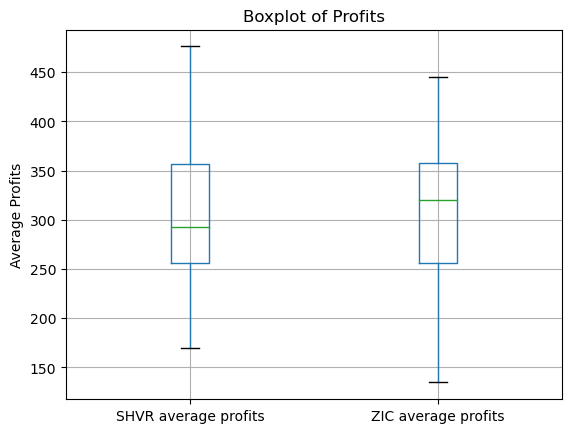

In [157]:
data_['df50_50'].boxplot(column=['SHVR average profits', 'ZIC average profits'])
plt.title('Boxplot of Profits')
plt.ylabel('Average Profits')
plt.show()

According to the box plot, we can know that there is a similar range of SHVR and ZIC, and the ZIC has the higher median average profit. On the whole, ZIC has lower extreme value than SHVR.

Secondly, we can see some basic statistics of the two data sets.

In [158]:
data_['df50_50'].describe()

,SHVR average profits,ZIC average profits
count,50.000000,50.000000
mean,301.836000,311.767000
std,71.130543,71.798493
min,170.100000,134.700000
25%,255.800000,256.500000
50%,292.725000,320.700000
75%,357.025000,358.225000
max,476.250000,445.050000


We can see ZIC has a slightly higher mean than SHVR.
They have similar standard deviation which means they have similar dispersion.
Additionally, SHVR has higher minimum and maximum profits than ZIC which can also be seen from the box plot.

Thirdly, I want to compare the two sets. 
The firstly thing is to determine whether the two data sets are normally distributed. I decided to draw a Q-Q plot to check the fist.

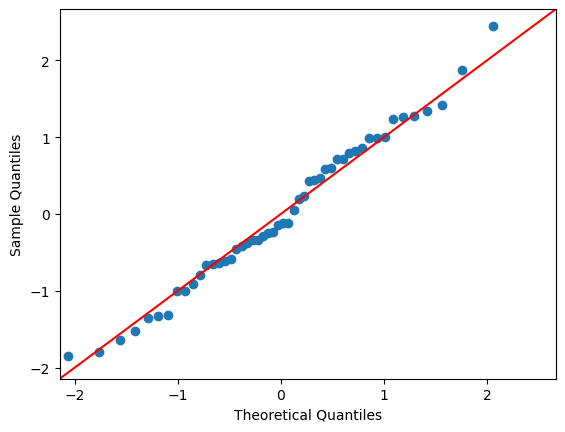

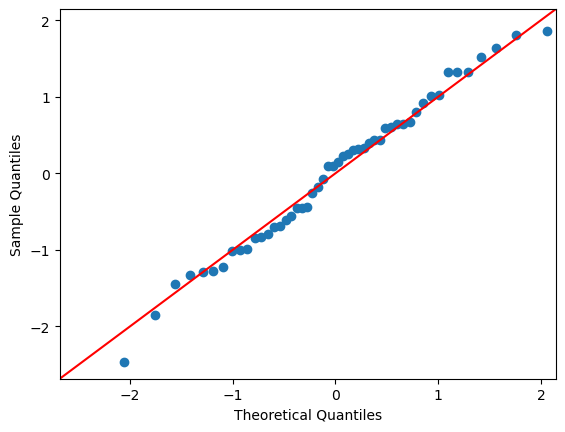

In [159]:
import statsmodels.api as sm
# normalise data
norm_x = (data_['df50_50']['SHVR average profits'] - data_['df50_50']['SHVR average profits'].mean())/data_['df50_50']['SHVR average profits'].std()
norm_y = (data_['df50_50']['ZIC average profits'] - data_['df50_50']['ZIC average profits'].mean())/data_['df50_50']['ZIC average profits'].std()
# create Q-Q plot with 45-degree line 
fig = sm.qqplot(norm_x, line='45') 
fig = sm.qqplot(norm_y, line='45')

It can be seen that both the two sets fall near the 45-degree line which means they are approximately normally distributed.
Furthermore, I use statistical test to determine.

In [160]:
# Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution
from scipy import stats

for col in data_['df50_50'].columns:
    statistic, pvalue = stats.shapiro(data_['df50_50'][col])
    if pvalue < 0.05:
        print("strategy " + "{:}".format(col) + 
              ". We can reject the null hypothesis (p=" + 
              "{:.2f}".format(pvalue) + 
              "). Therefore, data is not normally distributed.")
    else:
        print("strategy " + "{:}".format(col) + 
              ". We cannot reject the null hypothesis (p=" + 
              "{:.2f}".format(pvalue) + 
              "). Therefore, data is normally distributed.")

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.68). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.72). Therefore, data is normally distributed.


In conclusion, we can regard the two sets as normally distributed and perform correct hypothesis testing.
Since we compare two sets of data, we can use t-test. 
The data are not independent samples, so I will use a paired samples t-test.
The null hypothesis is that there is no significantly difference between SHVR average profits and ZIC average profits.

In [161]:
pair=['SHVR average profits','ZIC average profits']

# run the test
statistic, p=stats.ttest_rel(data_['df50_50'][pair[0]], data_['df50_50'][pair[1]])

# judge the results
if p < 0.05:
    print("Paired T-test: " + pair[0] + "/" + pair[1] 
          + " (p=" + "{:.3f}".format(p) + " < 0.05). " +
          "Reject null hypothesis that the paired samples " + 
          "have identical average values")
else:
    print("Paired T-test: "  + pair[0] + "/" + pair[1] + 
          " (p=" + "{:.3f}".format(p) + " > 0.05). " +
          "Cannot reject null hypothesis that the paired samples " +
          "have identical average values")


Paired T-test: SHVR average profits/ZIC average profits (p=0.625 > 0.05). Cannot reject null hypothesis that the paired samples have identical average values


The result shows that the p value>0.05, so we cannot reject null hypothesis which means the paired samples have identical average values.

We can know that the SHVR and ZIC traders have similar average profits.
There are several possible reasons. 
1. The time of our experiment was 10 minutes, which may be too short to let the strategy perform itself well.
2. Fifty trials may not be enough to find statistically difference of the two strategies. 
3. The stochastic nature of ZIC may produced a similar action with SHVR.

In [72]:
# run N=500
run_Vernon(N=500)

In [162]:
# invoke the combine_data function to combine data
combine_data(500,'df50_500',R_percen=0.5)

# print the result
print(data_['df50_500'])   # the name 'df50_500' means R=50,N=500

     SHVR average profits  ZIC average profits
0                  346.90               267.20
1                  370.25               244.90
2                  344.45               269.50
3                  304.65               310.50
4                  254.10               359.00
..                    ...                  ...
495                302.90               310.85
496                240.20               373.55
497                357.55               257.60
498                195.15               417.40
499                234.05               381.10

[500 rows x 2 columns]


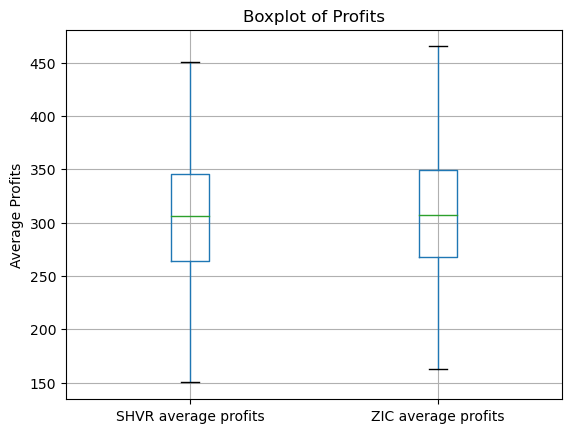

In [163]:
data_['df50_500'].boxplot(column=['SHVR average profits', 'ZIC average profits'])
plt.title('Boxplot of Profits')
plt.ylabel('Average Profits')
plt.show()

According to the box plot, we can know that there is a similar range of SHVR and ZIC, and the ZIC has the higher median average profit. On the whole, SHVR has lower extreme value than SHVR. 

In [164]:
# see some basic statistics of the two data sets
data_['df50_500'].describe()

,SHVR average profits,ZIC average profits
count,500.000000,500.000000
mean,304.862200,308.714300
std,57.704718,58.099967
min,150.050000,162.250000
25%,263.512500,268.000000
50%,306.200000,306.925000
75%,345.162500,349.150000
max,450.150000,465.100000


We can see ZIC has a slightly higher mean than SHVR.
They have similar standard deviation which means they have similar dispersion.
ZIC has higher minimum and maximum profits than SHVR which can also be seen from the box plot.

Determine whether the two data sets are normally distributed. 
I decided to draw a Q-Q plot to check the fist.

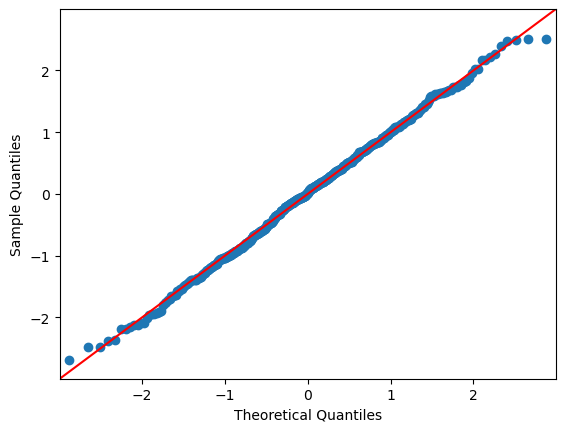

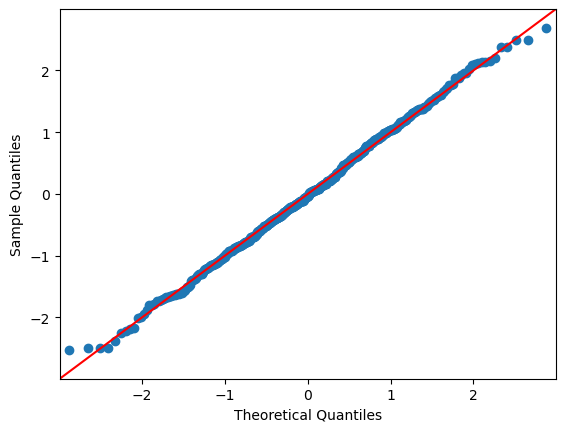

In [165]:
import statsmodels.api as sm
# normalise data
norm_x = (data_['df50_500']['SHVR average profits'] - data_['df50_500']['SHVR average profits'].mean())/data_['df50_500']['SHVR average profits'].std()
norm_y = (data_['df50_500']['ZIC average profits'] - data_['df50_500']['ZIC average profits'].mean())/data_['df50_500']['ZIC average profits'].std()
# create Q-Q plot with 45-degree line 
fig = sm.qqplot(norm_x, line='45') 
fig = sm.qqplot(norm_y, line='45')

It can be seen that both the two sets fall near the 45-degree line which means they are approximately normally distributed.
Furthermore, I use statistical test to determine.

In [167]:
# Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution
from scipy import stats

for col in data_['df50_500'].columns:
    statistic, pvalue = stats.shapiro(data_['df50_500'][col])
    if pvalue < 0.05:
        print("strategy " + "{:}".format(col) + 
              ". We can reject the null hypothesis (p=" + 
              "{:.2f}".format(pvalue) + 
              "). Therefore, data is not normally distributed.")
    else:
        print("strategy " + "{:}".format(col) + 
              ". We cannot reject the null hypothesis (p=" + 
              "{:.2f}".format(pvalue) + 
              "). Therefore, data is normally distributed.")

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.44). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.47). Therefore, data is normally distributed.


In conclusion, we can regard the two sets as normally distributed and perform correct hypothesis testing.
Since we compare two sets of data, we can use t-test. 
The data are not independent samples, so I will use a paired samples t-test.
The null hypothesis is that there is no significantly difference between SHVR average profits and ZIC average profits.

In [168]:
pair=['SHVR average profits','ZIC average profits']

# run the test
statistic, p=stats.ttest_rel(data_['df50_500'][pair[0]], data_['df50_500'][pair[1]])

# judge the results
if p < 0.05:
    print("Paired T-test: " + pair[0] + "/" + pair[1] 
          + " (p=" + "{:.3f}".format(p) + " < 0.05). " +
          "Reject null hypothesis that the paired samples " + 
          "have identical average values")
else:
    print("Paired T-test: "  + pair[0] + "/" + pair[1] + 
          " (p=" + "{:.3f}".format(p) + " > 0.05). " +
          "Cannot reject null hypothesis that the paired samples " +
          "have identical average values")


Paired T-test: SHVR average profits/ZIC average profits (p=0.457 > 0.05). Cannot reject null hypothesis that the paired samples have identical average values


The result shows that the p value>0.05, so we cannot reject null hypothesis which means the paired samples have identical average values.

We can know that the SHVR and ZIC traders have similar average profits.
There are several possible reasons. 
1. The time of our experiment was 10 minutes, which may be too short to let the strategy perform itself well.
2. The stochastic nature of ZIC may produced a similar action with SHVR.
The second reason of the experiment of N=50 is deleted, because I think N=500 is enough for us.

Part B:

In Part B, we have many R values. So we need to create a list to store these R values.

In [170]:
R_values=[10,20,30,40,60,70,80,90]
N_values=[50,500]
# use two nested loops to achieve the goal
for R in R_values:
    for N in N_values:
        run_Vernon(N=N, R_percen=R/100.0)  # invoke the run_Vernon function

In [171]:
# use another two nested loops to combine the data
for R in R_values:
    for N in N_values:
        data_name=f'df{R}_{N}'
        combine_data(N,data_name,R_percen=R/100.0) # # invoke the combine_data function


In [176]:
#for name in data_:
    #print(f'         basic statistics of {name}')    # type some spaces in the beginning to make the title centred
    #print(data_[name].describe())
   # print('\n')  # print \n to have a blank line


The following content is about analyzing the data.

In [172]:
import statsmodels.api as sm
from scipy import stats
def ana_R(name=None):
    data_[name].boxplot(column=['SHVR average profits', 'ZIC average profits'])
    plt.title('Boxplot of Profits')
    plt.ylabel('Average Profits')
    plt.show()

# see some basic statistics of the two data sets
    data_[name].describe()


# normalise data
    norm_x = (data_[name]['SHVR average profits'] - data_[name]['SHVR average profits'].mean())/data_[name]['SHVR average profits'].std()
    norm_y = (data_[name]['ZIC average profits'] - data_[name]['ZIC average profits'].mean())/data_[name]['ZIC average profits'].std()
# create Q-Q plot with 45-degree line 
    fig = sm.qqplot(norm_x, line='45') 
    fig = sm.qqplot(norm_y, line='45')

# Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution


    for col in data_[name].columns:
        statistic, pvalue = stats.shapiro(data_[name][col])
        if pvalue < 0.05:
            print("strategy " + "{:}".format(col) + 
              ". We can reject the null hypothesis (p=" + 
              "{:.2f}".format(pvalue) + 
              "). Therefore, data is not normally distributed.")
        else:
            print("strategy " + "{:}".format(col) + 
              ". We cannot reject the null hypothesis (p=" + 
              "{:.2f}".format(pvalue) + 
              "). Therefore, data is normally distributed.")

In [193]:
# if data is normally distributed, we can use paired t-test
def pb_t_test(name=None):
    pair=['SHVR average profits','ZIC average profits']

# run the test
    statistic, p=stats.ttest_rel(data_[name][pair[0]], data_[name][pair[1]])

# judge the results
    if p < 0.05:
        print("Paired T-test: " + pair[0] + "/" + pair[1] 
          + " (p=" + "{:.3f}".format(p) + " < 0.05). " +
          "Reject null hypothesis that the paired samples " + 
          "have identical average values")
    else:
        print("Paired T-test: "  + pair[0] + "/" + pair[1] + 
          " (p=" + "{:.3f}".format(p) + " > 0.05). " +
          "Cannot reject null hypothesis that the paired samples " +
          "have identical average values")


In [198]:
# if data is not normally distributed, we can use Mann-Whitney U
def mw_test(name):
    statistic, p=stats.mannwhitneyu(data_[name]['SHVR average profits'],data_[name]['ZIC average profits'])
    # judge the results
    if p < 0.05:
        print(" Mann-Whitney U test: " +"(p=" + " {:.3f}".format(p) + " < 0.05). " +
          "Reject null hypothesis that the samples " + 
          "have identical average values."+"   so there is significant difference in average profits")
    else:
        print(" Mann-Whitney U test: " +"(p=" + " {:.3f}".format(p) + " > 0.05). " +
          "Cannot reject null hypothesis that the samples " +
          "have identical average values")


'R=10' means there are 10% traders of type SHVR and 90% traders of type ZIC.
Because we have 20 buyers and 20 sellers, so we have 2 buyers of SHVR and 18 buyers of ZIC, and 2 sellers of SHVR and 18 sellers of ZIC.
R=10, N=50:

In [173]:
print(data_['df10_50'].describe())

       SHVR average profits  ZIC average profits
count             50.000000            50.000000
mean             350.475000           300.796111
std              173.233734            19.440797
min               67.250000           261.805556
25%              193.687500           289.125000
50%              364.500000           298.916667
75%              464.187500           318.409723
max              694.500000           331.583333


We can see SHVR has a higher mean than ZIC.
SHVR has a bigger standard deviation which because the different number of traders.
Fewer traders of SHVR causes high degree of uncertainty and it is sensitive to extreme values, resulting the high std.

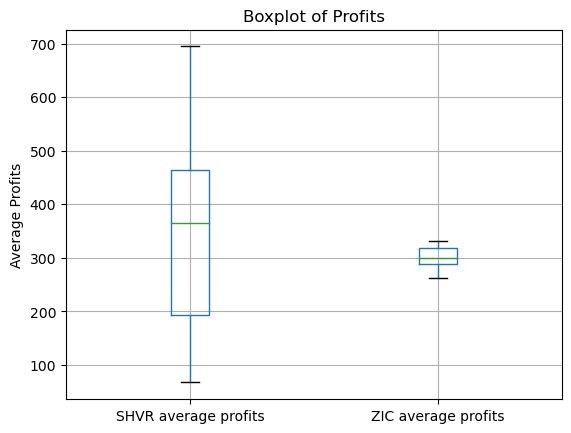

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.11). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.09). Therefore, data is normally distributed.


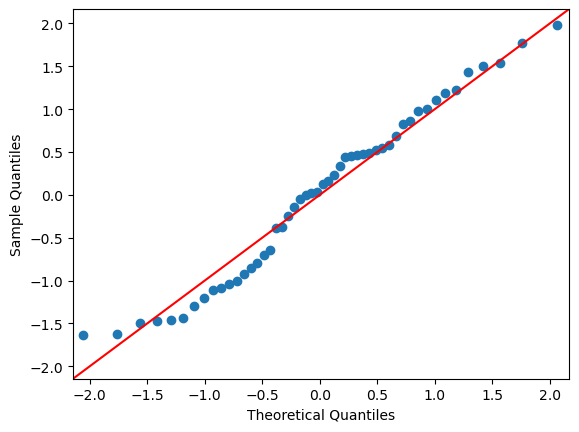

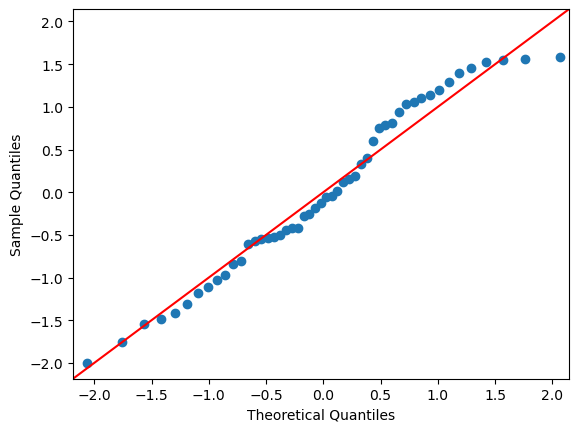

In [181]:
ana_R(name='df10_50')

In [182]:
pb_t_test(name='df10_50')

Paired T-test: SHVR average profits/ZIC average profits (p=0.074 > 0.05). Cannot reject null hypothesis that the paired samples have identical average values


R=10, N=500:

In [174]:
print(data_['df10_500'].describe())

       SHVR average profits  ZIC average profits
count            500.000000           500.000000
mean             327.676000           303.311167
std              171.571704            19.223942
min               44.000000           249.861111
25%              182.687500           290.486111
50%              323.375000           303.319445
75%              439.062500           319.638889
max              802.000000           335.333333


We can see SHVR has a higher mean than ZIC.
SHVR has a bigger standard deviation, the reason is same as 'N=50'.

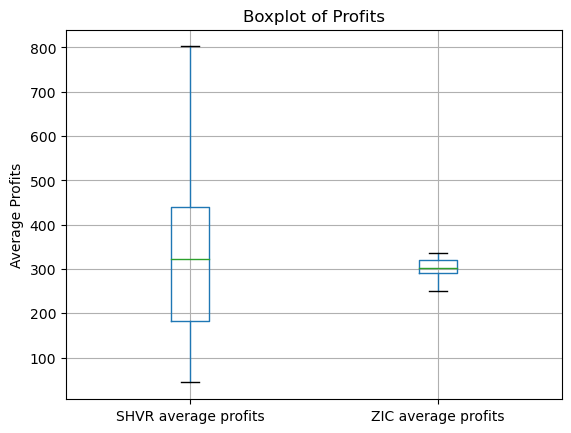

strategy SHVR average profits. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
strategy ZIC average profits. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.


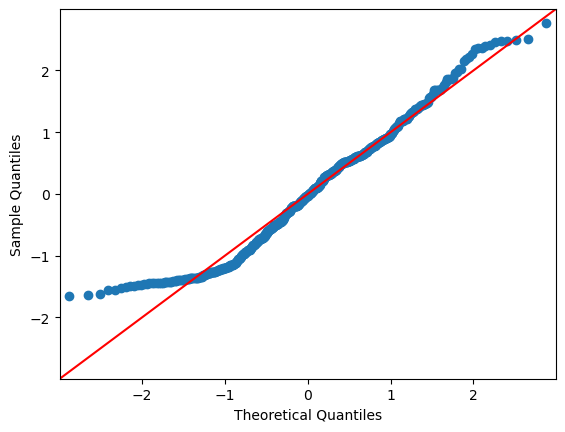

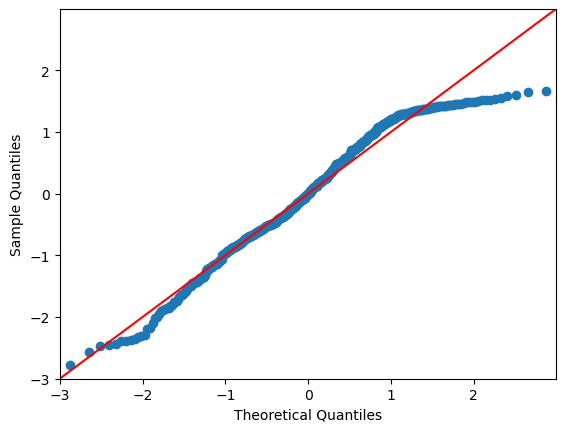

In [183]:
ana_R(name='df10_500')

In [199]:
mw_test('df10_500')

 Mann-Whitney U test: (p= 0.023 < 0.05). Reject null hypothesis that the samples have identical average values.   so there is significant difference in average profits


Then, we can compare the median value of the two strategies to find which strategy has the greater profit.
Since SHVR has a higher median than ZIC. 
So, SHVR is statistically more profitable than ZIC.

R=20, N=50:

In [201]:
print(data_['df20_50'].describe())

       SHVR average profits  ZIC average profits
count             50.000000            50.000000
mean             292.465000           309.311875
std              104.171188            26.094483
min               88.500000           248.187500
25%              221.062500           297.117188
50%              289.312500           310.125000
75%              338.468750           327.679688
max              541.000000           361.468750


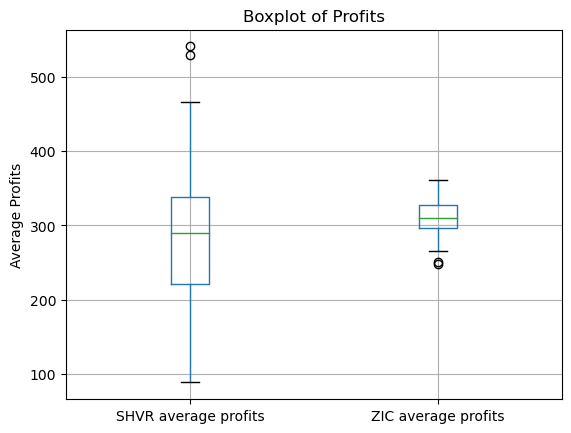

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.35). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.35). Therefore, data is normally distributed.


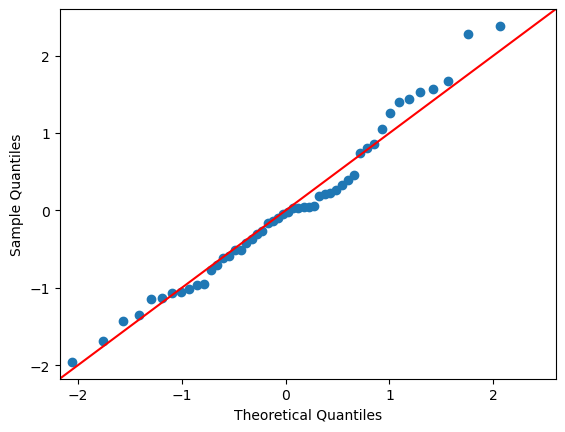

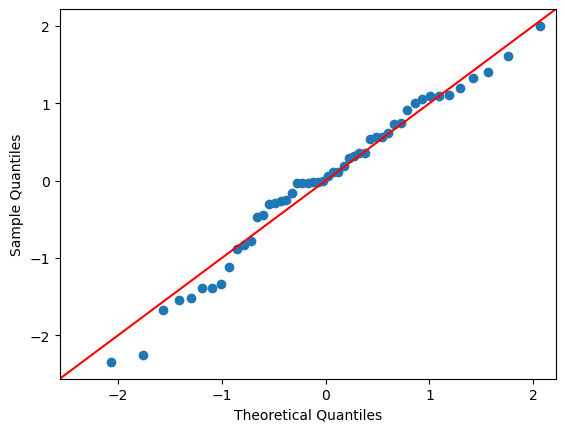

In [202]:
ana_R(name='df20_50')

In [203]:
pb_t_test(name='df20_50')

Paired T-test: SHVR average profits/ZIC average profits (p=0.365 > 0.05). Cannot reject null hypothesis that the paired samples have identical average values


R=20, N=500:

In [204]:
print(data_['df20_500'].describe())

       SHVR average profits  ZIC average profits
count            500.000000           500.000000
mean             327.001250           300.667750
std              108.686226            27.337368
min               58.125000           216.281250
25%              251.187500           282.304688
50%              328.125000           300.640625
75%              400.281250           318.890625
max              659.750000           368.031250


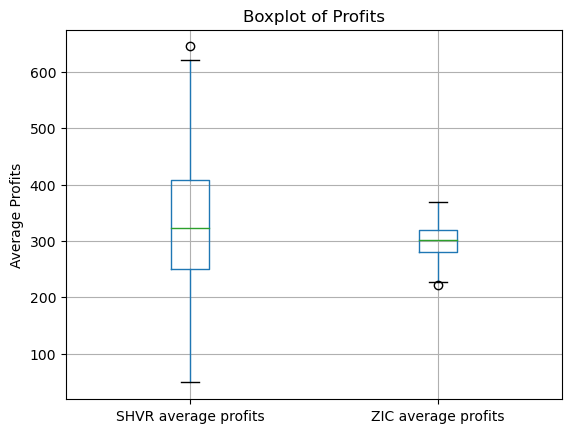

strategy SHVR average profits. We can reject the null hypothesis (p=0.04). Therefore, data is not normally distributed.
strategy ZIC average profits. We can reject the null hypothesis (p=0.04). Therefore, data is not normally distributed.


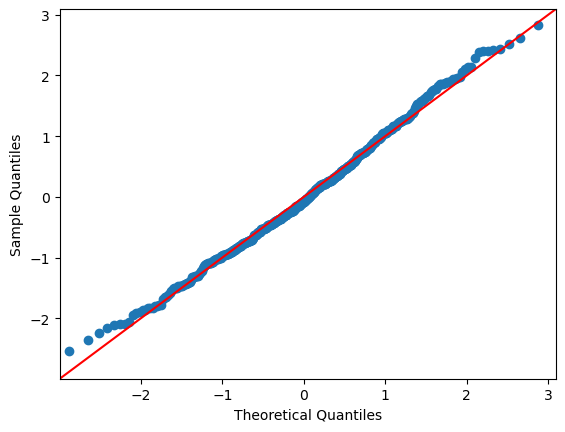

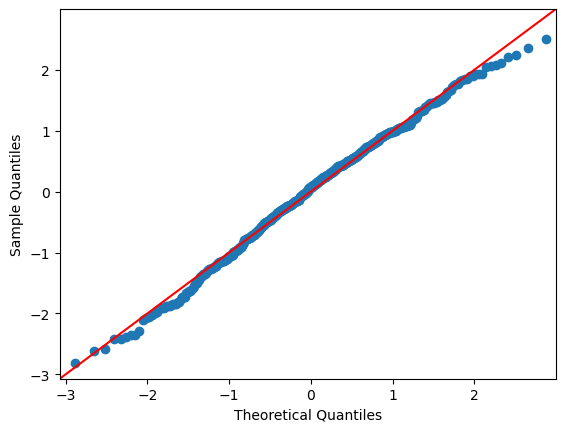

In [79]:
ana_R(name='df20_500')

In [205]:
mw_test('df20_500')

 Mann-Whitney U test: (p= 0.000 < 0.05). Reject null hypothesis that the samples have identical average values.   so there is significant difference in average profits


Since SHVR has a higher median than ZIC. 
So, SHVR is statistically more profitable than ZIC.

R=30,N=50:

In [212]:
print(data_['df30_50'].describe())

       SHVR average profits  ZIC average profits
count             50.000000            50.000000
mean             326.375000           297.196429
std               79.213397            34.413826
min              133.083333           218.071429
25%              268.937500           274.125000
50%              328.166667           295.714286
75%              382.041667           322.741071
max              511.666667           378.357143


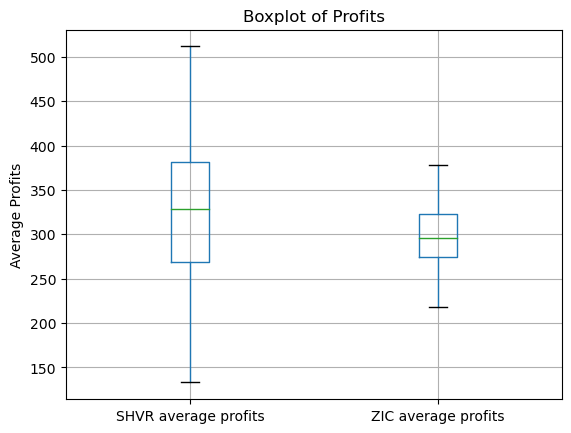

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.93). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.92). Therefore, data is normally distributed.


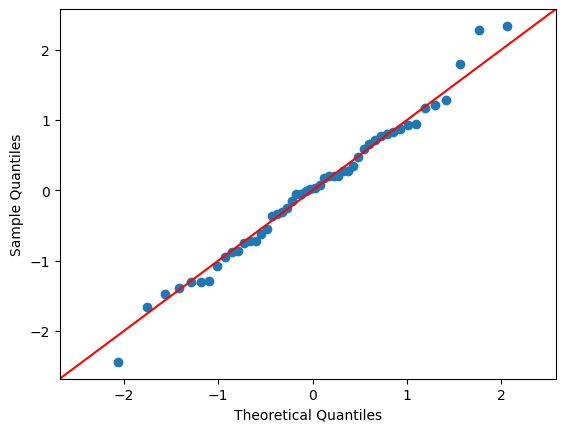

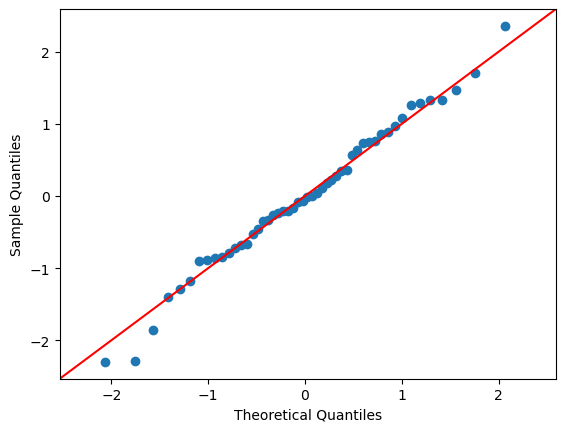

In [213]:
ana_R(name='df30_50')

In [214]:
pb_t_test(name='df30_50')

Paired T-test: SHVR average profits/ZIC average profits (p=0.075 > 0.05). Cannot reject null hypothesis that the paired samples have identical average values


R=30,N=500:

In [215]:
print(data_['df30_500'].describe())

       SHVR average profits  ZIC average profits
count            500.000000           500.000000
mean             313.194833           303.107286
std               83.946926            36.195234
min              110.166667           202.535714
25%              247.958333           277.133928
50%              312.833333           303.285714
75%              374.041667           331.258929
max              547.083333           390.571429


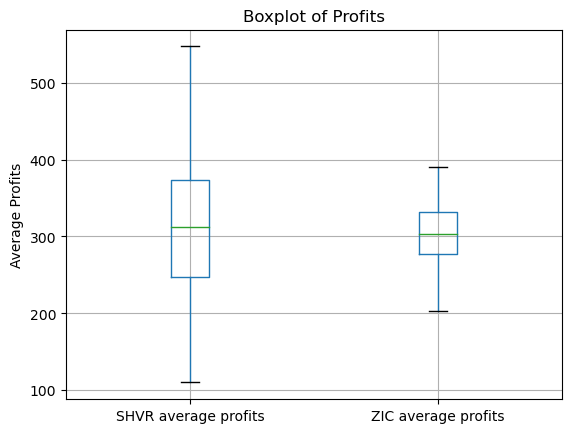

strategy SHVR average profits. We can reject the null hypothesis (p=0.03). Therefore, data is not normally distributed.
strategy ZIC average profits. We can reject the null hypothesis (p=0.03). Therefore, data is not normally distributed.


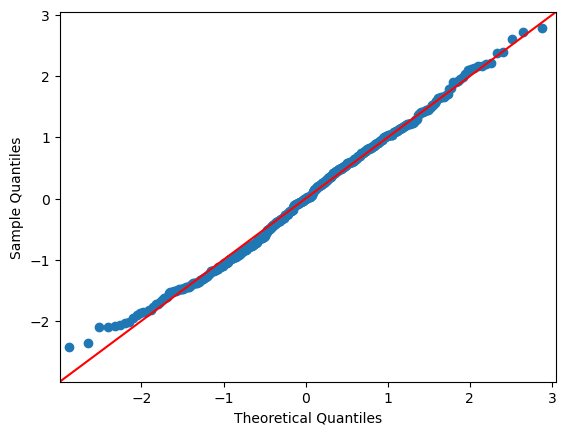

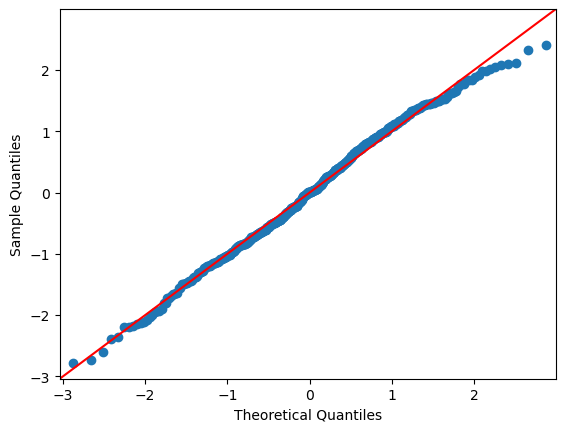

In [216]:
ana_R(name='df30_500')

In [217]:
mw_test('df30_500')

 Mann-Whitney U test: (p= 0.026 < 0.05). Reject null hypothesis that the samples have identical average values.   so there is significant difference in average profits


Since SHVR has a higher median than ZIC. 
So, SHVR is statistically more profitable than ZIC.

R=40,N=50:

In [218]:
print(data_['df40_50'].describe())

       SHVR average profits  ZIC average profits
count             50.000000            50.000000
mean             310.772500           303.605833
std               77.592684            52.092612
min              149.062500           178.333333
25%              252.406250           271.458333
50%              308.593750           305.333333
75%              357.437500           343.666667
max              498.812500           412.500000


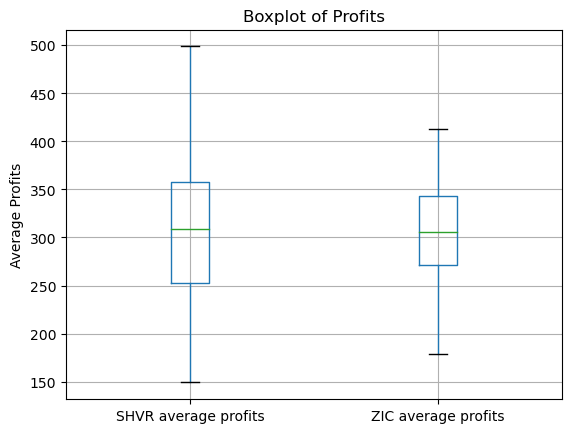

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.97). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.96). Therefore, data is normally distributed.


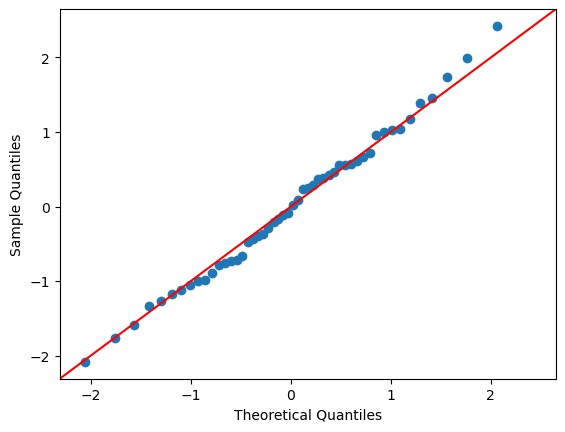

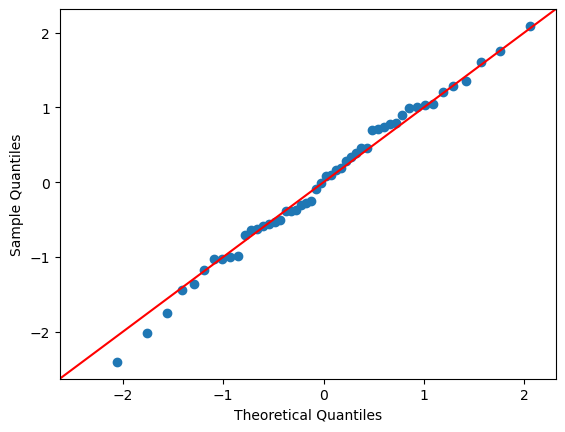

In [219]:
ana_R(name='df40_50')

In [220]:
pb_t_test(name='df40_50')

Paired T-test: SHVR average profits/ZIC average profits (p=0.698 > 0.05). Cannot reject null hypothesis that the paired samples have identical average values


R=40,N=500:

In [221]:
print(data_['df40_500'].describe())

       SHVR average profits  ZIC average profits
count            500.000000           500.000000
mean             310.477500           303.805500
std               71.750396            48.140692
min              106.187500           155.500000
25%              258.390625           271.250000
50%              307.375000           305.416667
75%              358.562500           338.687500
max              532.500000           438.791667


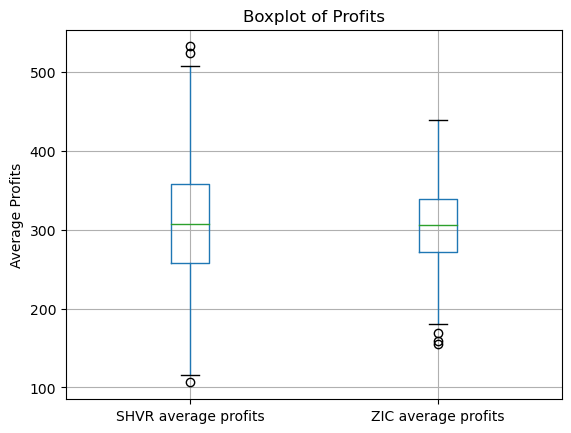

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.07). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.07). Therefore, data is normally distributed.


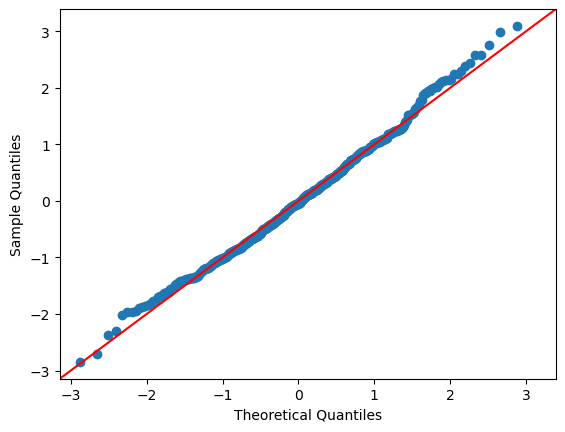

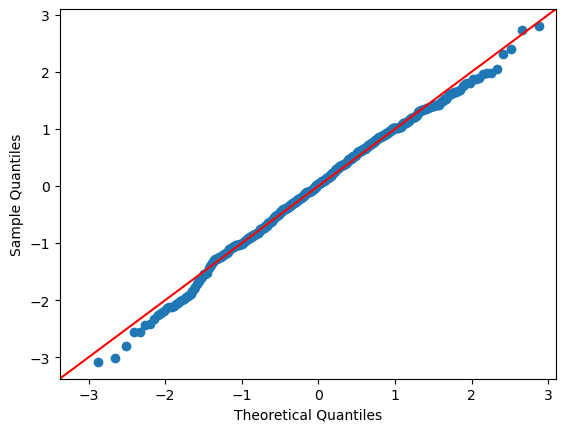

In [222]:
ana_R(name='df40_500')

In [223]:
pb_t_test(name='df40_500')

Paired T-test: SHVR average profits/ZIC average profits (p=0.214 > 0.05). Cannot reject null hypothesis that the paired samples have identical average values


R=60,N=50:

In [224]:
print(data_['df60_50'].describe())

       SHVR average profits  ZIC average profits
count             50.000000            50.000000
mean             311.863333           299.577500
std               48.549430            73.236212
min              189.166667           132.812500
25%              277.958333           243.437500
50%              318.312500           289.281250
75%              348.552083           350.421875
max              423.083333           485.187500


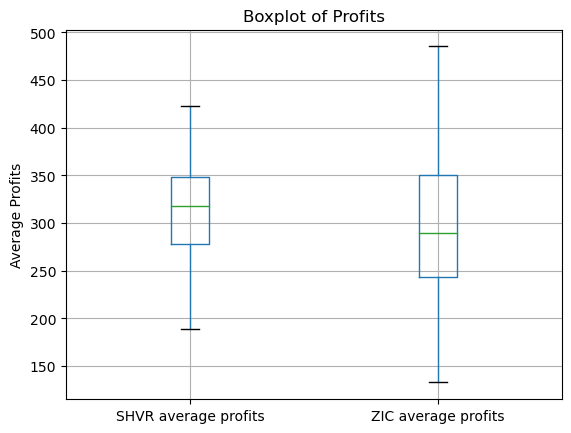

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.69). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.67). Therefore, data is normally distributed.


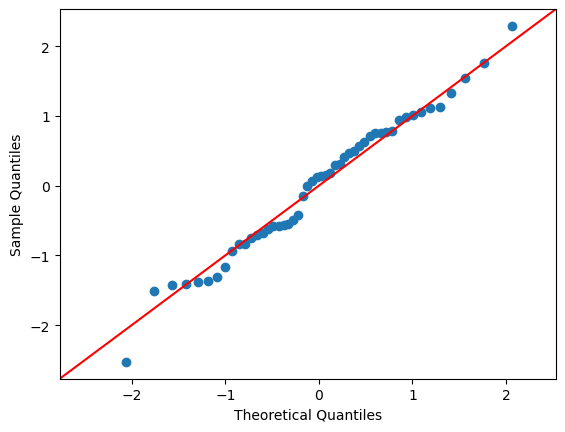

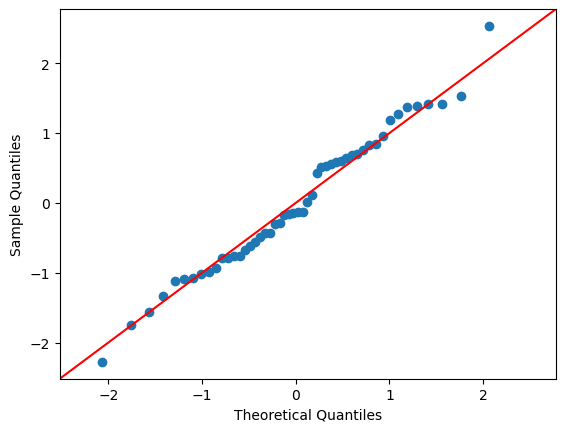

In [225]:
ana_R(name='df60_50')

In [226]:
pb_t_test(name='df60_50')

Paired T-test: SHVR average profits/ZIC average profits (p=0.479 > 0.05). Cannot reject null hypothesis that the paired samples have identical average values


R=60,N=500:

In [227]:
print(data_['df60_500'].describe())

       SHVR average profits  ZIC average profits
count            500.000000           500.000000
mean             308.814667           304.175625
std               48.807265            73.614593
min              179.125000            73.812500
25%              275.541667           253.218750
50%              306.083333           308.343750
75%              341.385417           354.640625
max              462.416667           498.562500


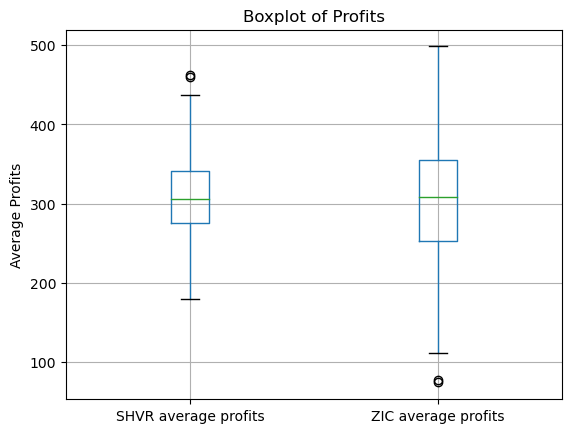

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.34). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.33). Therefore, data is normally distributed.


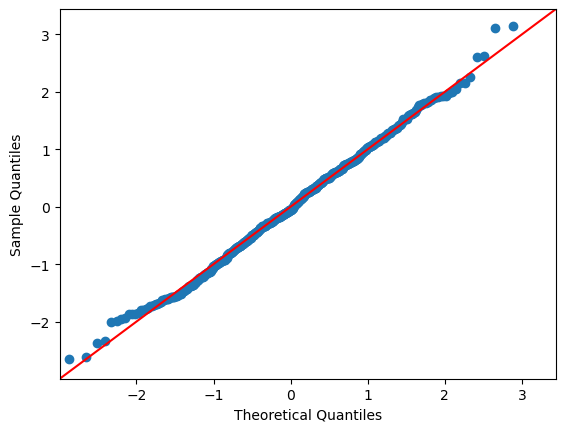

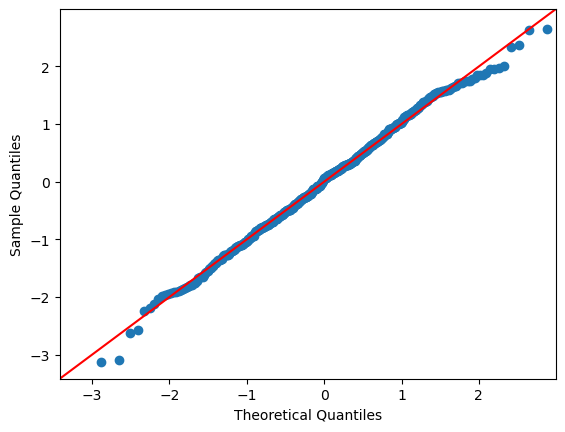

In [228]:
ana_R(name='df60_500')

In [229]:
pb_t_test(name='df60_500')

Paired T-test: SHVR average profits/ZIC average profits (p=0.397 > 0.05). Cannot reject null hypothesis that the paired samples have identical average values


R=70,N=50:

In [230]:
print(data_['df70_50'].describe())

       SHVR average profits  ZIC average profits
count             50.000000            50.000000
mean             305.193571           312.196667
std               37.423249            87.516522
min              227.821429            62.416667
25%              273.750000           243.333333
50%              303.571429           314.041667
75%              334.946429           384.750000
max              411.785714           493.666667


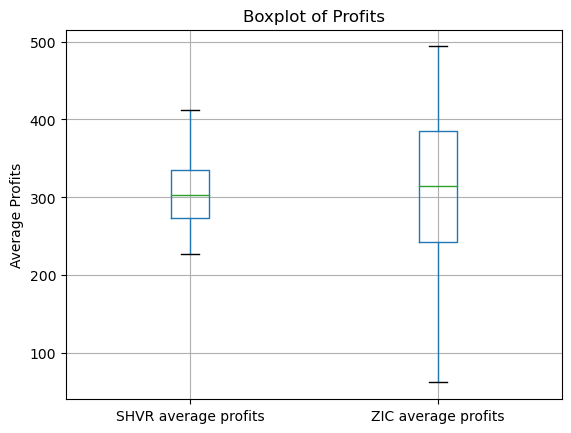

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.30). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.28). Therefore, data is normally distributed.


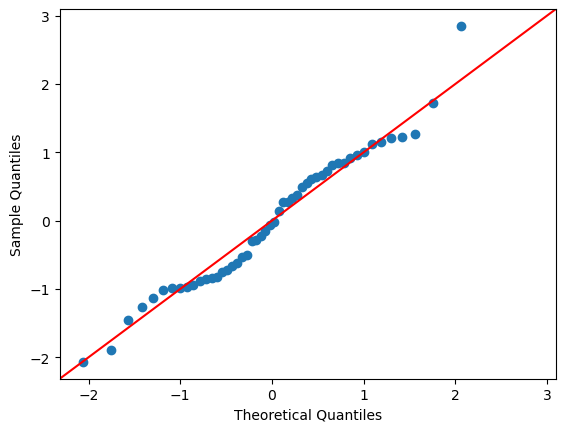

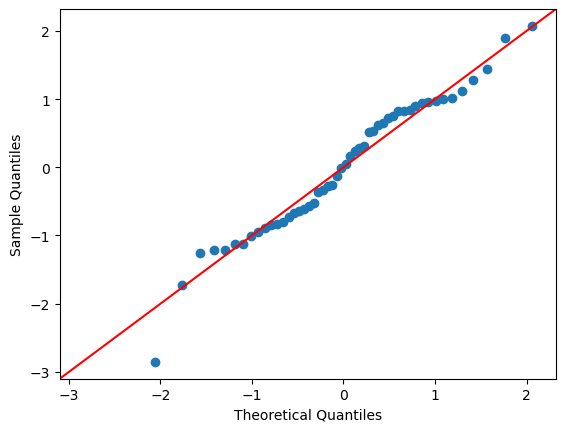

In [231]:
ana_R(name='df70_50')

In [232]:
pb_t_test(name='df70_50')

Paired T-test: SHVR average profits/ZIC average profits (p=0.694 > 0.05). Cannot reject null hypothesis that the paired samples have identical average values


R=70,N=500:

In [233]:
print(data_['df70_500'].describe())

       SHVR average profits  ZIC average profits
count            500.000000           500.000000
mean             304.811143           313.121500
std               40.521329            94.943266
min              179.678571            51.500000
25%              276.267857           251.395833
50%              304.535715           314.000000
75%              331.276786           380.145833
max              416.571429           606.000000


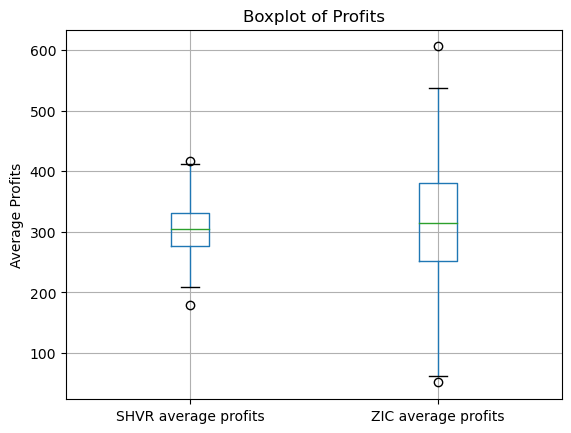

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.13). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.13). Therefore, data is normally distributed.


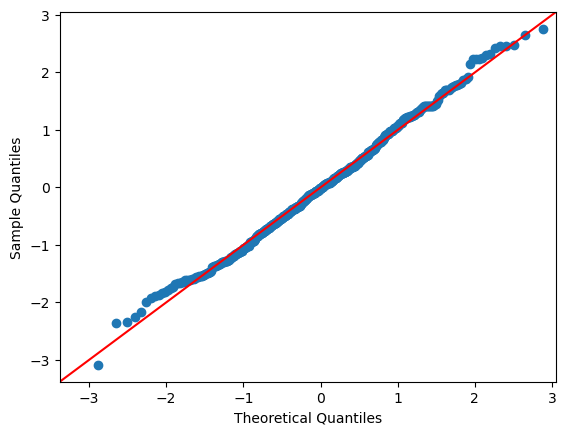

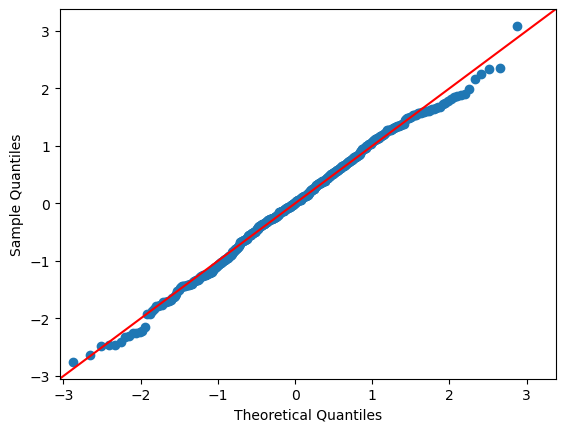

In [234]:
ana_R(name='df70_500')

In [235]:
pb_t_test(name='df70_500')

Paired T-test: SHVR average profits/ZIC average profits (p=0.171 > 0.05). Cannot reject null hypothesis that the paired samples have identical average values


R=80,N=50:

In [236]:
print(data_['df80_50'].describe())

       SHVR average profits  ZIC average profits
count             50.000000            50.000000
mean             314.017500           281.457500
std               30.494852           121.871489
min              253.468750            16.875000
25%              291.914062           199.781250
50%              313.156250           285.250000
75%              334.523438           370.218750
max              380.250000           524.000000


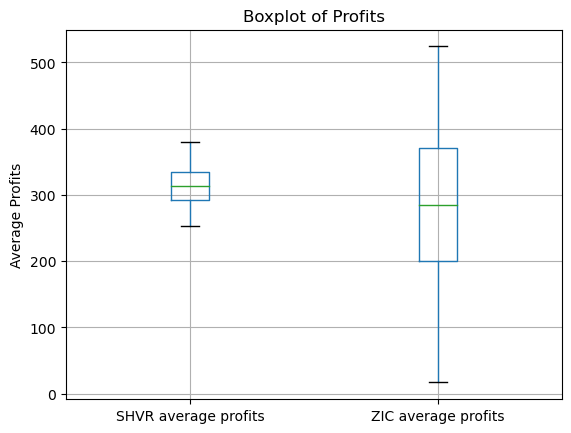

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.47). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.46). Therefore, data is normally distributed.


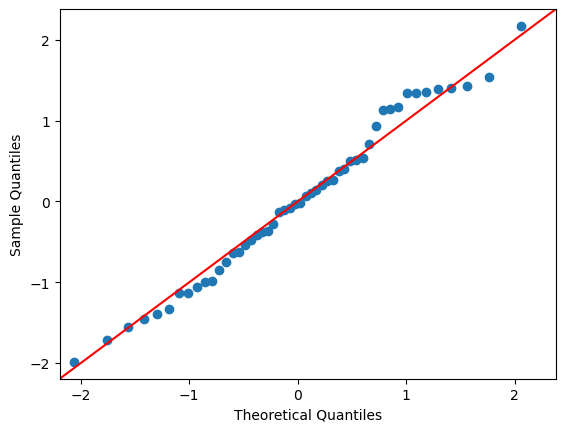

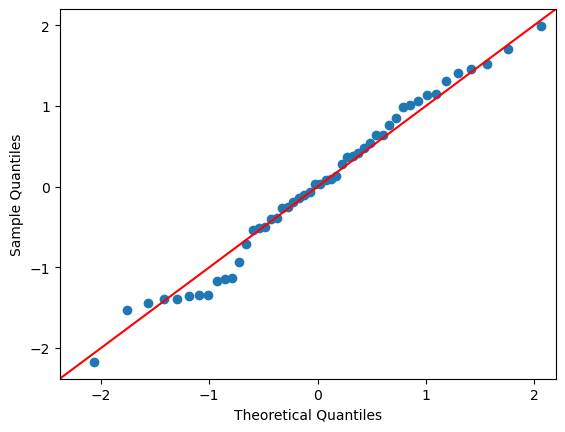

In [237]:
ana_R(name='df80_50')

In [238]:
pb_t_test(name='df80_50')

Paired T-test: SHVR average profits/ZIC average profits (p=0.137 > 0.05). Cannot reject null hypothesis that the paired samples have identical average values


R=80,N=500:

In [239]:
print(data_['df80_500'].describe())

       SHVR average profits  ZIC average profits
count            500.000000           500.000000
mean             305.015562           317.181000
std               32.101196           128.689479
min              205.593750             0.000000
25%              283.304688           229.781250
50%              303.234375           324.062500
75%              326.796875           404.406250
max              384.468750           715.500000


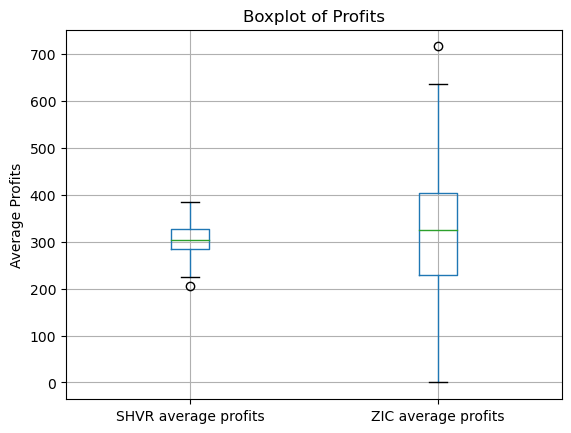

strategy SHVR average profits. We cannot reject the null hypothesis (p=0.24). Therefore, data is normally distributed.
strategy ZIC average profits. We cannot reject the null hypothesis (p=0.23). Therefore, data is normally distributed.


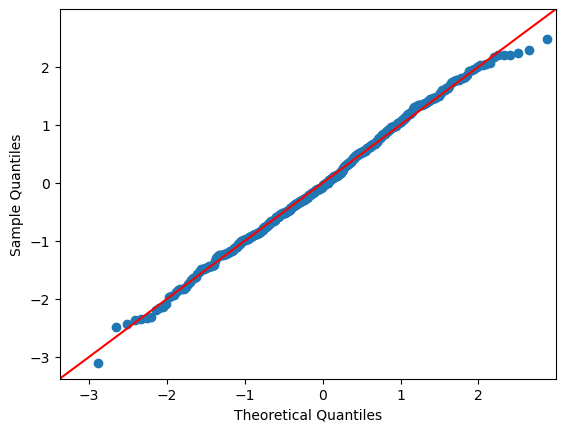

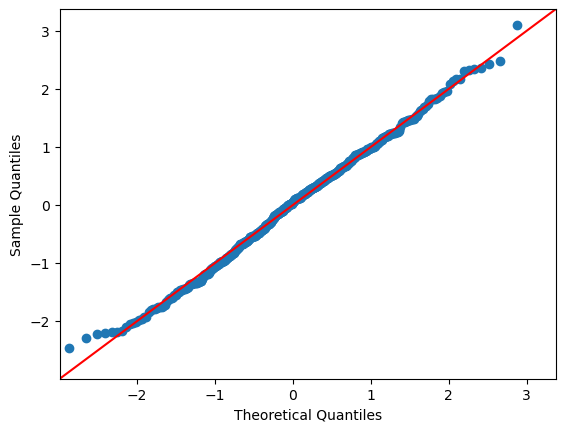

In [240]:
ana_R(name='df80_500')

In [241]:
pb_t_test(name='df80_500')

Paired T-test: SHVR average profits/ZIC average profits (p=0.091 > 0.05). Cannot reject null hypothesis that the paired samples have identical average values


R=90,N=50:

In [242]:
print(data_['df90_50'].describe())

       SHVR average profits  ZIC average profits
count             50.000000            50.000000
mean             309.012778           294.035000
std               19.779096           178.594534
min              273.722222             0.000000
25%              292.027778           153.625000
50%              307.888889           304.000000
75%              324.680555           447.500000
max              341.750000           612.250000


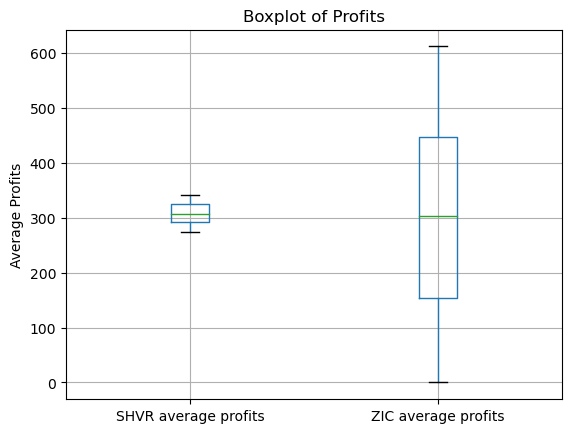

strategy SHVR average profits. We can reject the null hypothesis (p=0.03). Therefore, data is not normally distributed.
strategy ZIC average profits. We can reject the null hypothesis (p=0.03). Therefore, data is not normally distributed.


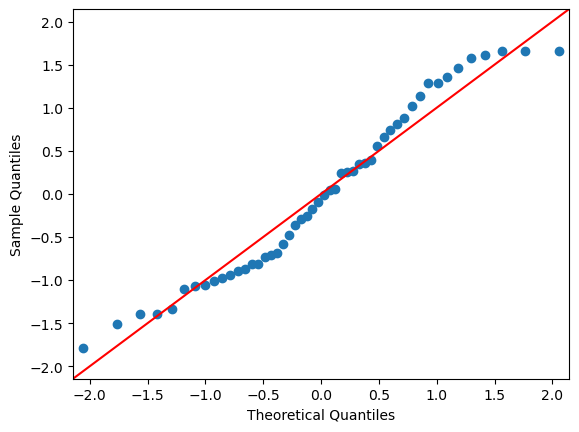

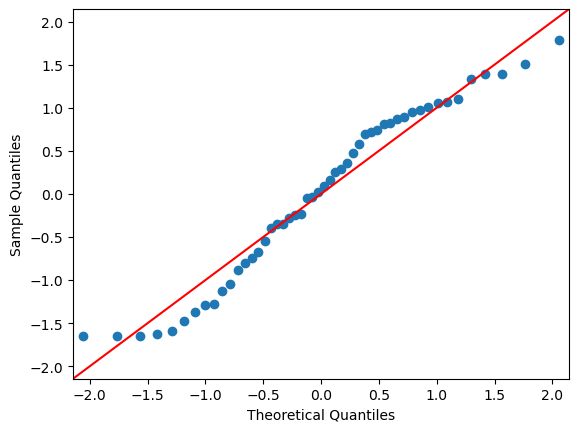

In [243]:
ana_R(name='df90_50')

In [244]:
mw_test('df90_50')

 Mann-Whitney U test: (p= 0.937 > 0.05). Cannot reject null hypothesis that the samples have identical average values


R=90,N=500:

In [245]:
print(data_['df90_500'].describe())

       SHVR average profits  ZIC average profits
count            500.000000           500.000000
mean             306.515500           316.397000
std               20.676376           186.667169
min              259.583333             0.000000
25%              292.472223           167.937500
50%              306.263889           318.500000
75%              322.909722           443.500000
max              341.750000           739.500000


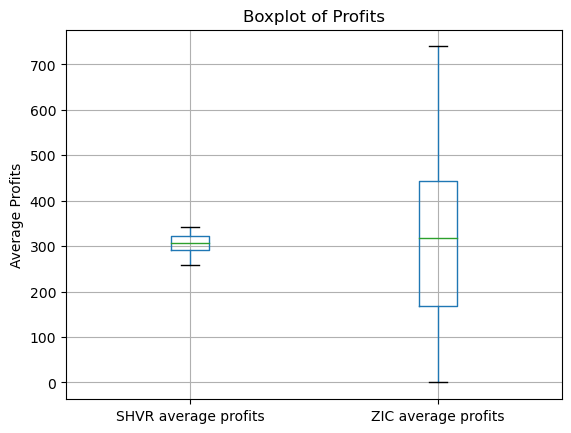

strategy SHVR average profits. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.
strategy ZIC average profits. We can reject the null hypothesis (p=0.00). Therefore, data is not normally distributed.


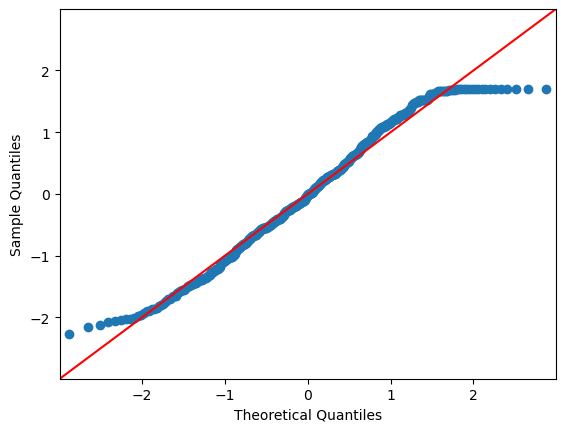

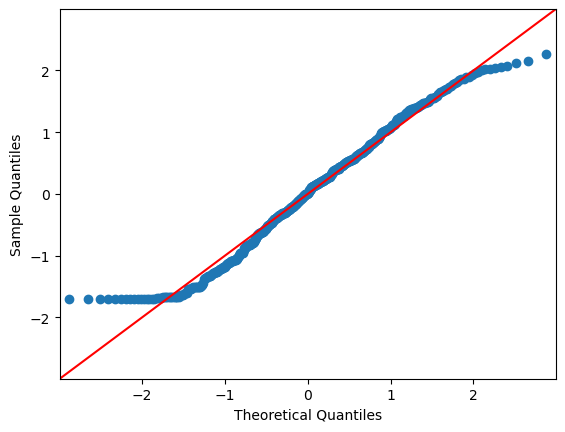

In [246]:
ana_R(name='df90_500')

In [247]:
mw_test('df90_500')

 Mann-Whitney U test: (p= 0.155 > 0.05). Cannot reject null hypothesis that the samples have identical average values


Part C:

In [101]:
# create run_Vernon_four function to run the new experiment
def run_Vernon_four(N=1,end_time=60*10,ratios=None,num=1):
    start_time=0
    end_time=60*10
    # the supply curve is a horizontal line of P=310 and the demand curve is a sloping line from 490 to 250
    supply=(310,310)
    demand=(490,250)

    supply_schedule=[{'from': start_time, 'to': end_time, 'ranges': [supply], 'stepmode': 'fixed'}]
    demand_schedule=[{'from': start_time, 'to': end_time, 'ranges': [demand], 'stepmode': 'fixed'}]
  
    order_interval=60

    order_sched={'sup': supply_schedule, 'dem': demand_schedule,
                'interval': order_interval, 'timemode': 'periodic'}

    num_of_traders=20 
    SHVR_num=int(ratios[0]*num_of_traders)
    GVWY_num=int(ratios[1]*num_of_traders)
    ZIC_num=int(ratios[2]*num_of_traders)
    ZIP_num=int(ratios[3]*num_of_traders)
    sellers_spec=[('SHVR',SHVR_num),('GVWY',GVWY_num),('ZIC', ZIC_num),('ZIP',ZIP_num)]
    buyers_spec=sellers_spec
    traders_spec={'sellers':sellers_spec,'buyers':buyers_spec}
   
    # we are only interested in average profits per trader. We set all other flags to False.
    dump_flags={'dump_blotters': False, 'dump_lobs': False, 'dump_strats': False,
              'dump_avgbals': True, 'dump_tape': False}

    # run N trials of this experiment configuration

    for i in range(N):
        trial_id=str(i)+'pc'+'_'+str(num)
        verbose=False 
        market_session(trial_id, start_time, end_time, traders_spec, order_sched, dump_flags, verbose)




# define all required ratios
ratios_all=[
    [0.25, 0.25, 0.25, 0.25], # num=1
    [0.4, 0.2, 0.2, 0.2],     # num=2
    [0.2, 0.4, 0.2, 0.2],     # num=3
    [0.2, 0.2, 0.4, 0.2],     # num=4
    [0.2, 0.2, 0.2, 0.4],     # num=5
    [0.1, 0.3, 0.3, 0.3],     # num=6
    [0.3, 0.1, 0.3, 0.3],     # num=7
    [0.3, 0.3, 0.1, 0.3],     # num=8
    [0.3, 0.3, 0.3, 0.1],     # num=9
    [0.7, 0.1, 0.1, 0.1],     # num=10
    [0.1, 0.7, 0.1, 0.1],     # num=11
    [0.1, 0.1, 0.7, 0.1],     # num=12
    [0.1, 0.1, 0.1, 0.7]      # num=13
]


In [102]:
# run all 
i_num=1
for r in ratios_all:
    run_Vernon_four(N=50,end_time=60*10,ratios=r,num=i_num)
    i_num+=1


In [248]:
def pc_combine_data(N,data_name,num): 
    C_folder_path='/Users/guzhemeimao/Downloads/'
    C_file_paths=glob.glob(C_folder_path+f'*pc_{num}_avg_balance.csv')
    
    GVWY_values=[]
    # get the last row
    for C_file_path in C_file_paths: 
        C_df = pd.read_csv(C_file_path)
        last_row=C_df.dropna().tail(1)
        if not last_row.empty:
            GVWY_value=last_row.iloc[0,7]  
            
        # check if the value is numeric before appending
            if pd.notna(GVWY_value) and pd.to_numeric(GVWY_value, errors='coerce')==GVWY_value:
                GVWY_values.append(GVWY_value)
  
 # repeat the process to get the useful data of SHVR, ZIC, ZIP
    SHVR_values=[]
    # get the last row
    for C_file_path in C_file_paths: 
            C_df = pd.read_csv(C_file_path)
            last_row=C_df.dropna().tail(1)
            if not last_row.empty:
                SHVR_value=last_row.iloc[0,11]  
            
        # check if the value is numeric before appending
                if pd.notna(SHVR_value) and pd.to_numeric(SHVR_value, errors='coerce')==SHVR_value:
                    SHVR_values.append(SHVR_value)
    ZIC_values=[]
    for C_file_path in C_file_paths: 
            C_df = pd.read_csv(C_file_path)
            last_row=C_df.dropna().tail(1)
            if not last_row.empty:
                ZIC_value=last_row.iloc[0,15]
       
                if pd.notna(ZIC_value) and pd.to_numeric(ZIC_value, errors='coerce')==ZIC_value:
                     ZIC_values.append(ZIC_value)
    ZIP_values=[]
    for C_file_path in C_file_paths:  
            C_df = pd.read_csv(C_file_path)
            last_row=C_df.dropna().tail(1)
            if not last_row.empty:
                ZIP_value=last_row.iloc[0,19]
       
                if pd.notna(ZIP_value) and pd.to_numeric(ZIP_value, errors='coerce')==ZIP_value:
                    ZIP_values.append(ZIP_value)
# convert the list to some new DataFrame
    df1=pd.DataFrame({'GVWY': GVWY_values})
    df2=pd.DataFrame({'SHVR': SHVR_values})  
    df3=pd.DataFrame({'ZIC': ZIC_values})
    df4=pd.DataFrame({'ZIP': ZIP_values})
# combine the df1, df2, df3, df4 into df
    df=pd.concat([df1, df2, df3, df4], axis=1)

    data_C[data_name]=df

    

# create a empty dictionary to store the name
data_c={}

In [249]:
# create a function to visualize and analyse
def pc_ana(data_name='C_df_1'):
    data_C[data_name].boxplot(column=['GVWY','SHVR', 'ZIC','ZIP'])
    plt.title('Boxplot of Profits')
    plt.ylabel('Average Profits')
    plt.show()

# normalise data
    norm_1 = (data_C[data_name]['GVWY'] - data_C[data_name]['GVWY'].mean())/data_C[data_name]['GVWY'].std()
    norm_2 = (data_C[data_name]['SHVR'] - data_C[data_name]['SHVR'].mean())/data_C[data_name]['SHVR'].std()
    norm_3 = (data_C[data_name]['ZIC'] - data_C[data_name]['ZIC'].mean())/data_C[data_name]['ZIC'].std()
    norm_4 = (data_C[data_name]['ZIP'] - data_C[data_name]['ZIP'].mean())/data_C[data_name]['ZIP'].std()
# create Q-Q plot with 45-degree line 
    fig = sm.qqplot(norm_1, line='45') 
    fig = sm.qqplot(norm_2, line='45')
    fig = sm.qqplot(norm_3, line='45') 
    fig = sm.qqplot(norm_4, line='45')
# Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution


    for col in data_C[data_name].columns:
        statistic, pvalue = stats.shapiro(data_C[data_name][col])
        if pvalue < 0.05:
            print("strategy " + "{:}".format(col) + 
              ". We can reject the null hypothesis (p=" + 
              "{:.2f}".format(pvalue) + 
              "). Therefore, data is not normally distributed.")
        else:
            print("strategy " + "{:}".format(col) + 
              ". We cannot reject the null hypothesis (p=" + 
              "{:.2f}".format(pvalue) + 
              "). Therefore, data is normally distributed.")
    

visualization and test: ANOVA is designed to compare multiple distributions, so we use ANOVA when data is normally distributed. When data is not normally distributed, we use Kruskal-Wallis.

In [251]:
def anova(data_name):
    statistic, pvalue = stats.f_oneway(data_C[data_name]['GVWY'],data_C[data_name]['SHVR'],data_C[data_name]['ZIC'],data_C[data_name]['ZIP'])
    if pvalue < 0.05:
        print("ANOVA: (p=" + "{:.2f}".format(pvalue) + 
          " < 0.05). Reject null. The groups have a " +
          "different population mean.") 
    else:
        print("ANOVA: (p=" + "{:.2f}".format(pvalue) + 
          " > 0.05). Cannot reject null hypothesis " + 
          "that groups have same population mean.")

In [252]:
def kw(data_name):
    statistic, pvalue = stats.kruskal(data_C[data_name]['GVWY'],data_C[data_name]['SHVR'],data_C[data_name]['ZIC'],data_C[data_name]['ZIP'])
    
    # judge the results
    if pvalue < 0.05:
        print("Kruskal-Wallis  test: " +"(p=" + " {:.3f}".format(pvalue) + " < 0.05). " +
          "Reject null hypothesis that the samples " + 
          "have identical average values."+"   so there is significant difference in profits")
    else:
        print("Kruskal-Wallis  test: " +"(p=" + " {:.3f}".format(pvalue) + " > 0.05). " +
          "Cannot reject null hypothesis that the samples " +
          "have identical average values")

[0.25, 0.25, 0.25, 0.25]:


In [250]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_1',1)  # num='1'indicate the ratio of (25:25:25:25)

In [117]:
# see some basic statistics of the data sets
data_C['C_df_1'].describe()

,GVWY,SHVR,ZIC,ZIP
count,50.000000,50.000000,50.000000,50.000000
mean,279.734000,292.746000,331.342000,322.692000
std,97.398185,104.175813,93.715386,93.100996
min,94.300000,105.600000,90.800000,82.400000
25%,198.050000,209.375000,277.975000,263.800000
50%,288.750000,263.000000,335.100000,322.900000
75%,353.025000,380.475000,410.200000,391.350000
max,468.800000,534.200000,506.900000,490.500000


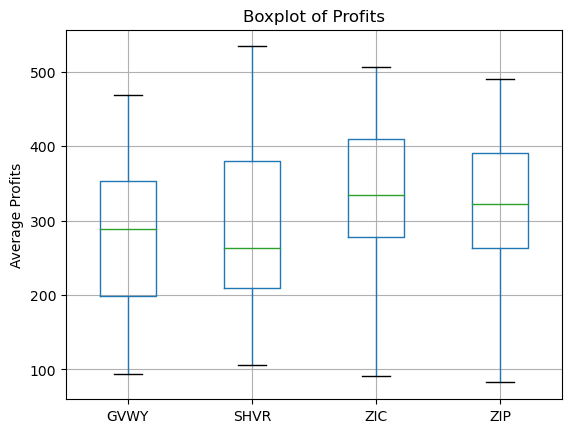

strategy GVWY. We cannot reject the null hypothesis (p=0.22). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.06). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.58). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.23). Therefore, data is normally distributed.


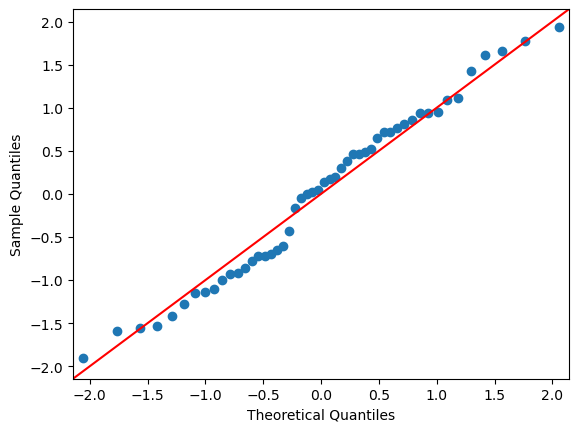

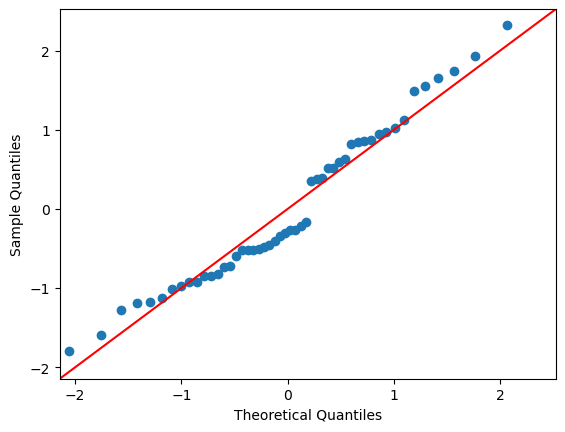

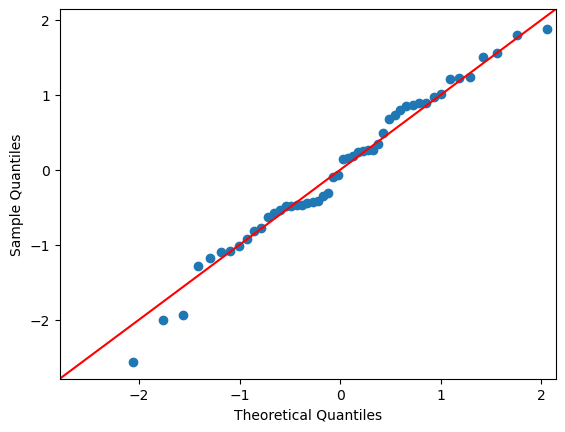

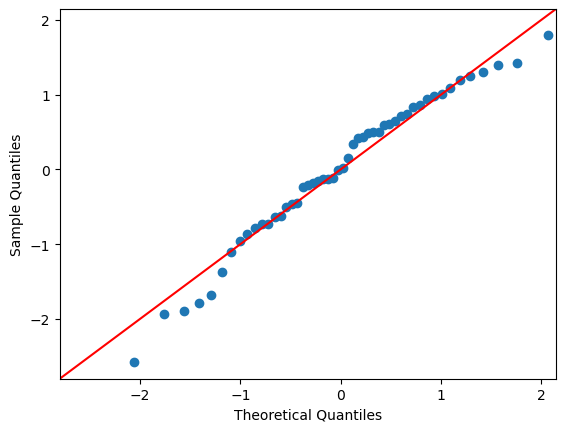

In [118]:
pc_ana('C_df_1')

In [253]:
anova('C_df_1')

ANOVA: (p=0.03 < 0.05). Reject null. The groups have a different population mean.


[0.4, 0.2, 0.2, 0.2]     # num=2

In [254]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_2',2)  

In [255]:
# see some basic statistics of the data sets
data_C['C_df_2'].describe()

,GVWY,SHVR,ZIC,ZIP
count,50.000000,50.000000,50.000000,50.000000
mean,292.332500,300.825000,312.815000,327.950000
std,88.575071,67.777421,91.763037,116.221444
min,142.750000,143.125000,122.750000,117.500000
25%,242.875000,245.203125,249.531250,244.843750
50%,278.750000,320.531250,320.625000,343.187500
75%,335.500000,349.765625,368.875000,409.187500
max,528.375000,464.062500,518.375000,593.375000


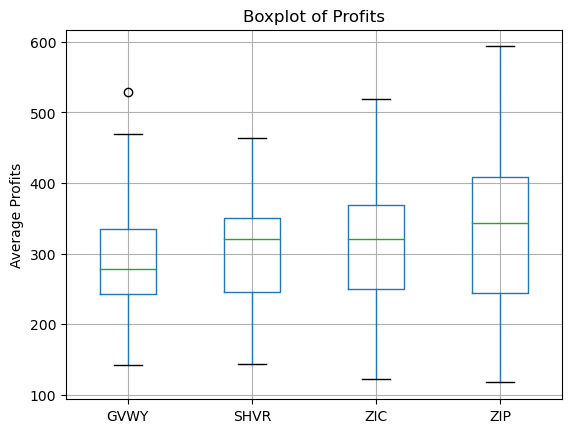

strategy GVWY. We cannot reject the null hypothesis (p=0.13). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.09). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.97). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.41). Therefore, data is normally distributed.


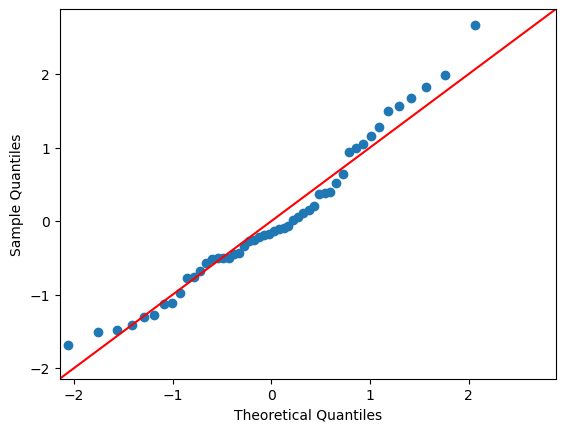

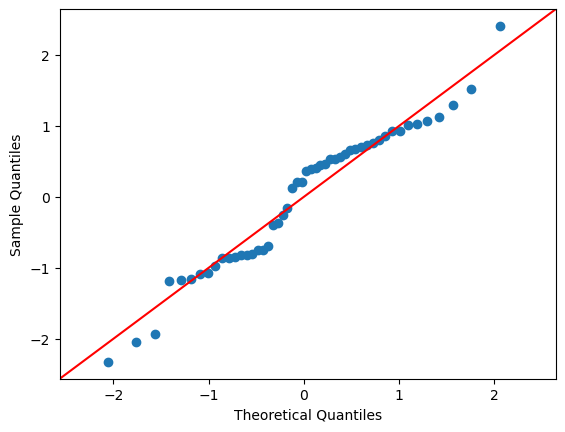

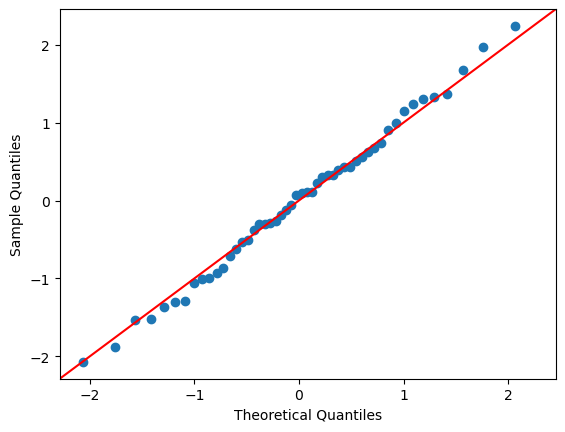

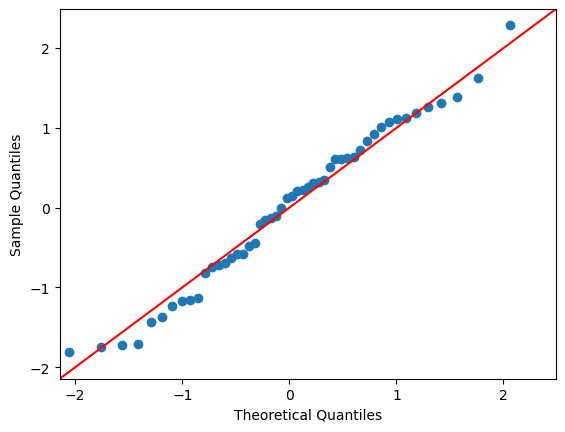

In [256]:
pc_ana('C_df_2')

In [257]:
anova('C_df_2')

ANOVA: (p=0.25 > 0.05). Cannot reject null hypothesis that groups have same population mean.


 [0.2, 0.4, 0.2, 0.2],     # num=3


In [258]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_3',3)  

In [259]:
# see some basic statistics of the data sets
data_C['C_df_3'].describe()

,GVWY,SHVR,ZIC,ZIP
count,50.000000,50.000000,50.000000,50.000000
mean,279.410000,299.267500,329.287500,347.815000
std,69.989980,121.555976,125.182689,120.333683
min,157.687500,63.250000,53.375000,32.125000
25%,230.296875,207.156250,242.281250,283.968750
50%,274.781250,319.250000,329.500000,342.687500
75%,315.828125,365.156250,443.593750,421.062500
max,459.062500,538.125000,550.500000,627.875000


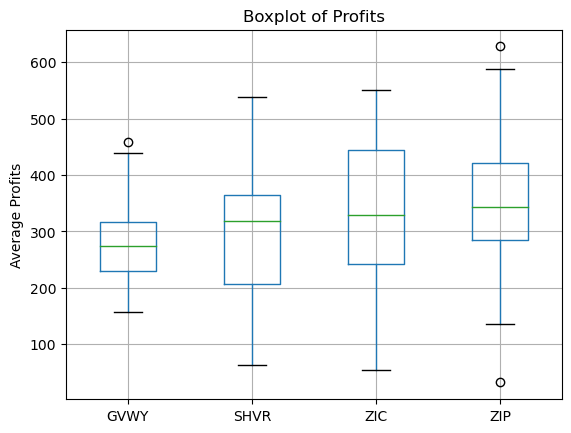

strategy GVWY. We cannot reject the null hypothesis (p=0.21). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.24). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.42). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.95). Therefore, data is normally distributed.


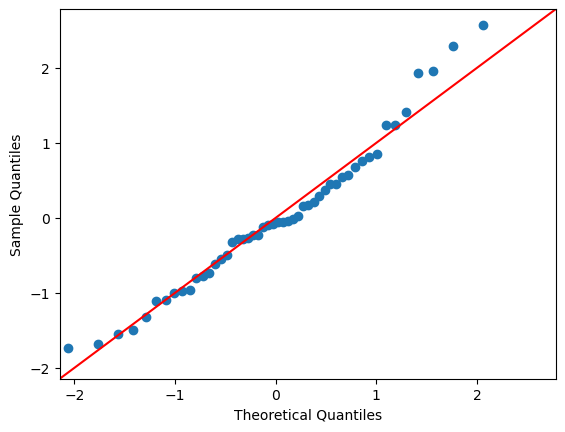

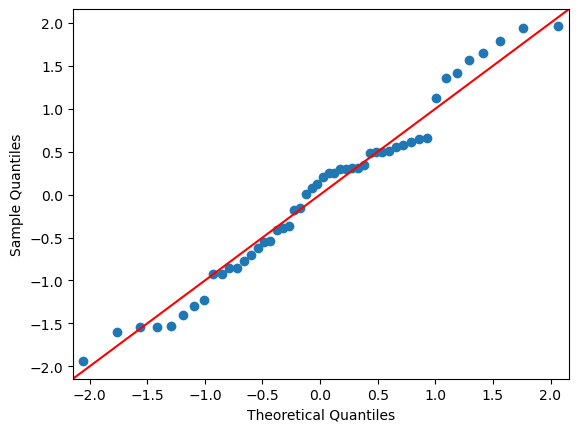

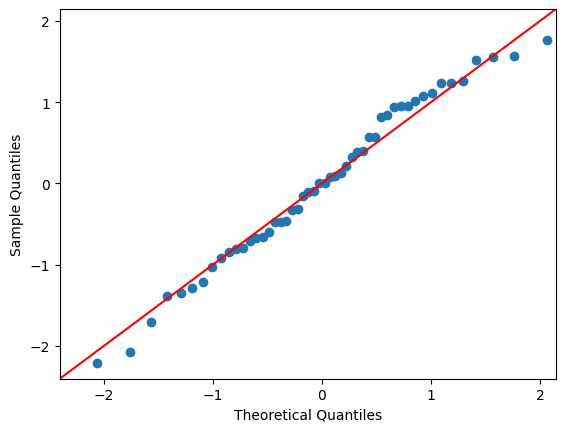

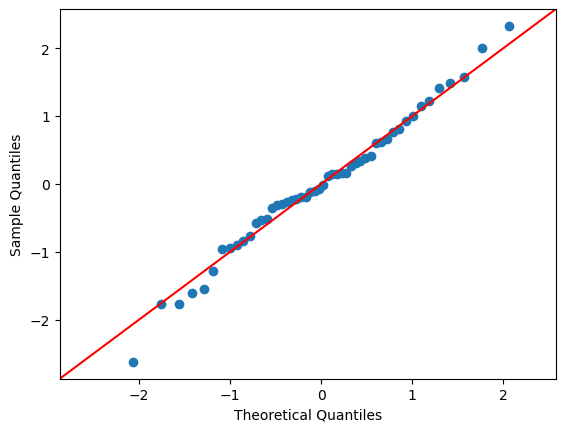

In [125]:
pc_ana('C_df_3')

In [260]:
anova('C_df_3')

ANOVA: (p=0.01 < 0.05). Reject null. The groups have a different population mean.


    [0.2, 0.2, 0.4, 0.2],     # num=4


In [261]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_4',4) 

In [262]:
# see some basic statistics of the data sets
data_C['C_df_4'].describe()

,GVWY,SHVR,ZIC,ZIP
count,50.000000,50.000000,50.000000,50.000000
mean,291.217500,313.230000,303.221250,321.242500
std,97.655902,124.001351,61.652533,98.395811
min,102.500000,74.250000,125.875000,85.625000
25%,233.625000,221.312500,264.375000,254.000000
50%,300.125000,301.750000,306.406250,340.937500
75%,346.093750,394.468750,334.500000,374.093750
max,532.125000,550.500000,470.375000,534.125000


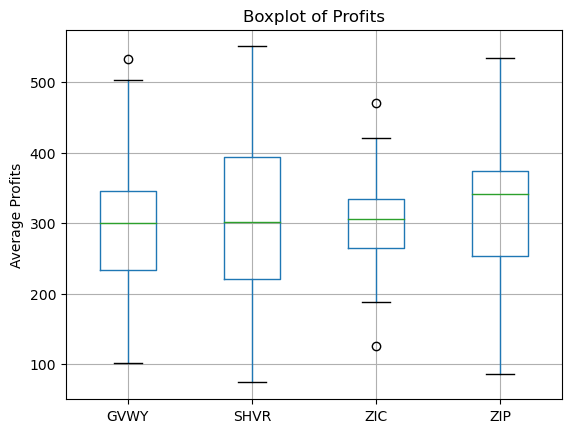

strategy GVWY. We cannot reject the null hypothesis (p=0.67). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.32). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.76). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.23). Therefore, data is normally distributed.


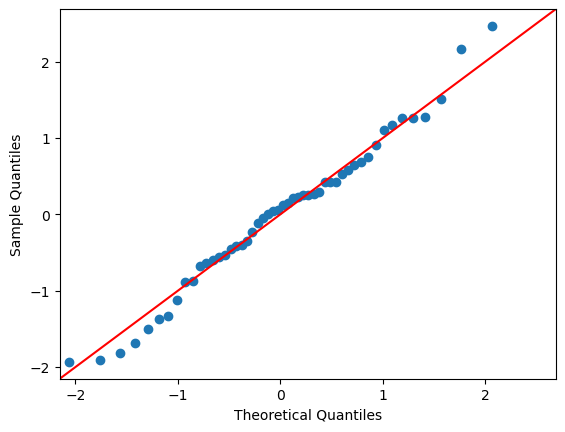

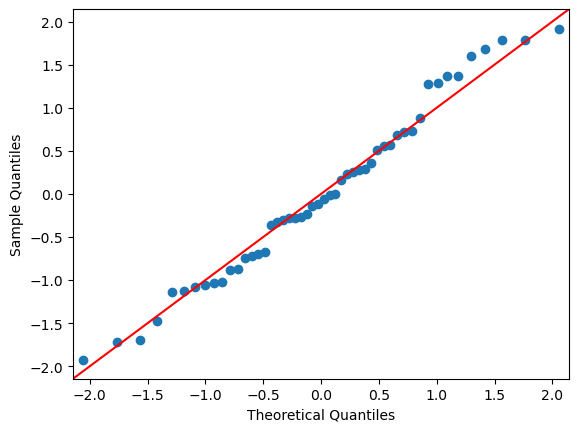

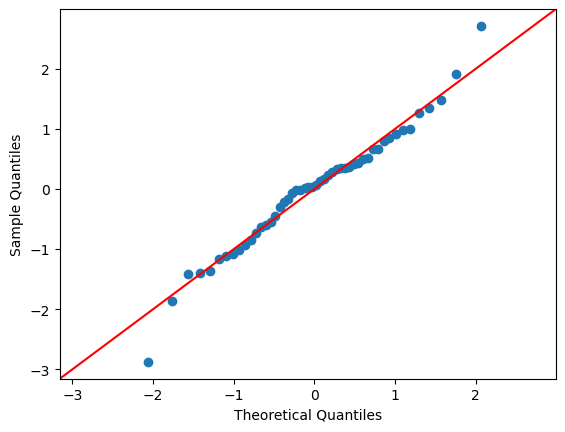

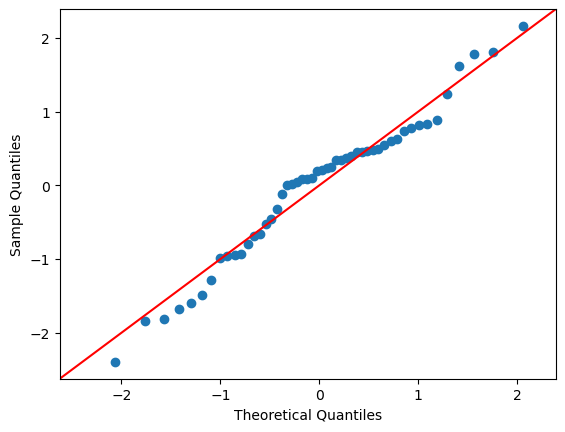

In [128]:
pc_ana('C_df_4')

In [263]:
anova('C_df_4')

ANOVA: (p=0.45 > 0.05). Cannot reject null hypothesis that groups have same population mean.


    [0.2, 0.2, 0.2, 0.4],     # num=5


In [264]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_5',5) 

In [265]:
# see some basic statistics of the data sets
data_C['C_df_5'].describe()

,GVWY,SHVR,ZIC,ZIP
count,50.000000,50.00000,50.000000,50.000000
mean,274.932500,279.87500,326.575000,324.946250
std,112.572899,123.41794,108.460996,73.229919
min,33.250000,27.37500,128.625000,186.250000
25%,184.062500,197.75000,248.937500,267.453125
50%,253.625000,298.87500,328.250000,324.093750
75%,328.156250,368.21875,422.875000,381.421875
max,584.500000,506.50000,579.000000,458.125000


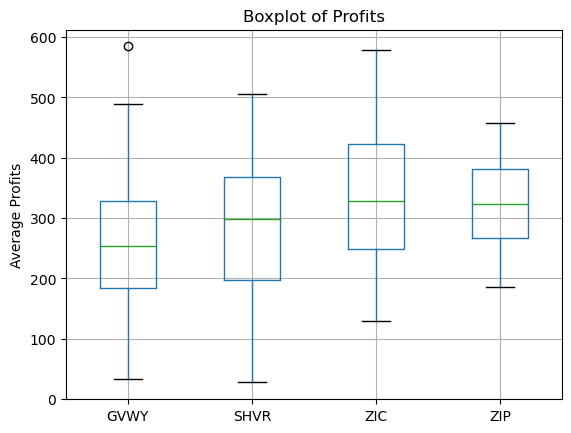

strategy GVWY. We can reject the null hypothesis (p=0.04). Therefore, data is not normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.15). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.38). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.19). Therefore, data is normally distributed.


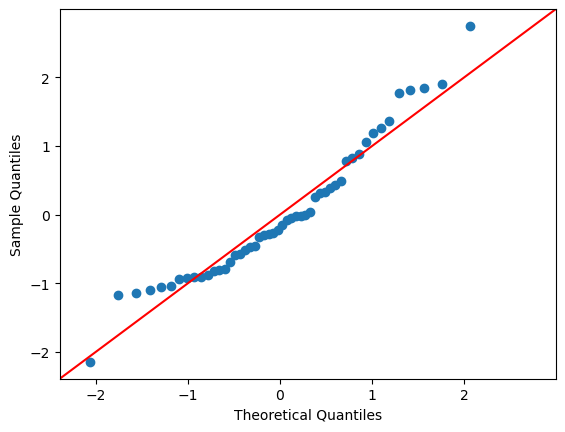

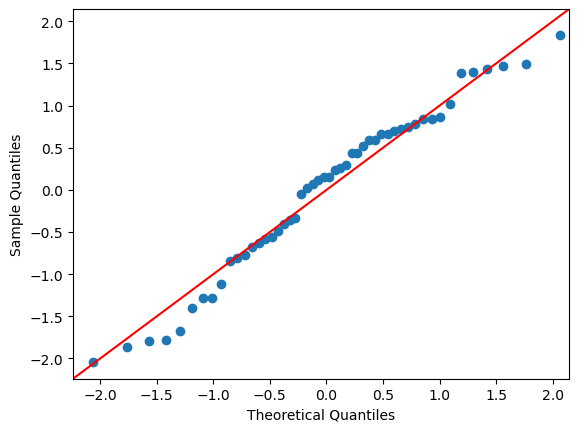

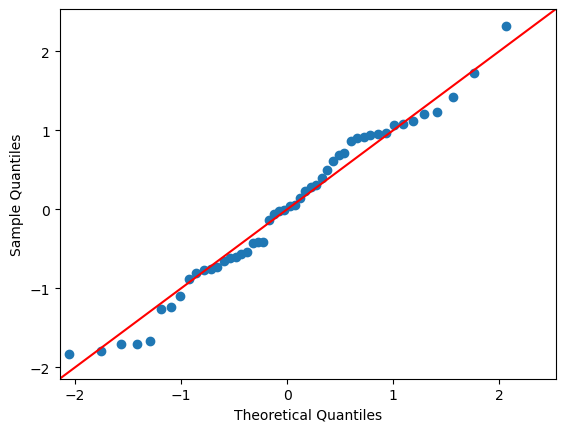

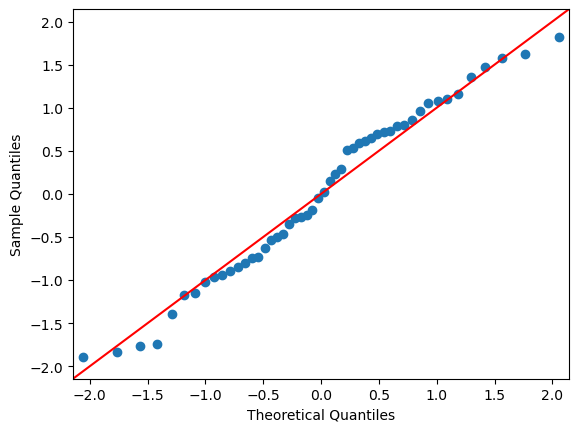

In [131]:
pc_ana('C_df_5')

In [266]:
kw('C_df_5')

Kruskal-Wallis  test: (p= 0.015 < 0.05). Reject null hypothesis that the samples have identical average values.   so there is significant difference in profits


    [0.1, 0.3, 0.3, 0.3],     # num=6


In [267]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_6',6) 

In [268]:
# see some basic statistics of the data sets
data_C['C_df_6'].describe()

,GVWY,SHVR,ZIC,ZIP
count,50.000000,50.000000,50.000000,50.000000
mean,261.836667,299.050000,343.045000,315.921667
std,76.587531,181.111041,88.568976,75.851481
min,85.833333,8.000000,137.250000,184.500000
25%,209.125000,149.562500,278.354167,268.520833
50%,254.791667,293.000000,346.375000,307.208333
75%,316.750000,401.250000,404.270833,359.958333
max,436.083333,655.000000,574.833333,519.083333


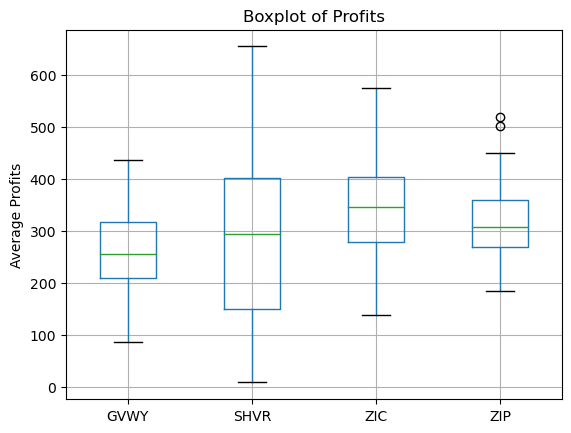

strategy GVWY. We cannot reject the null hypothesis (p=1.00). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.06). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=1.00). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.31). Therefore, data is normally distributed.


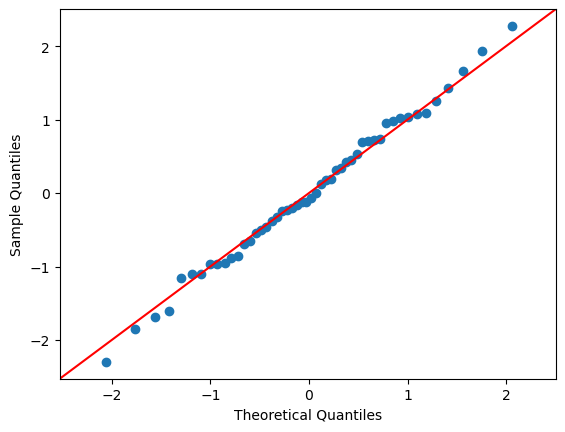

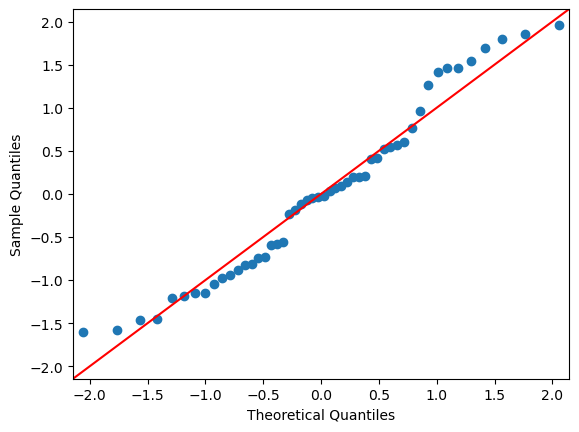

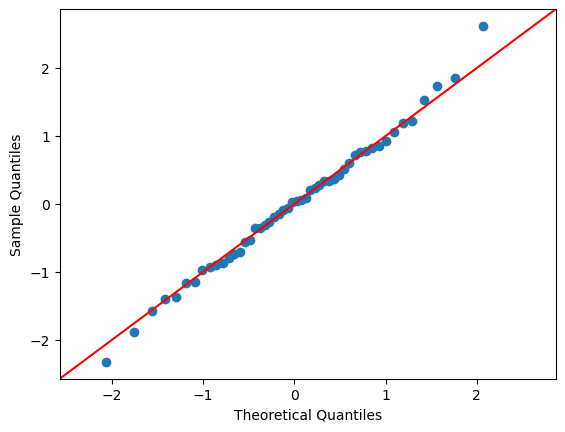

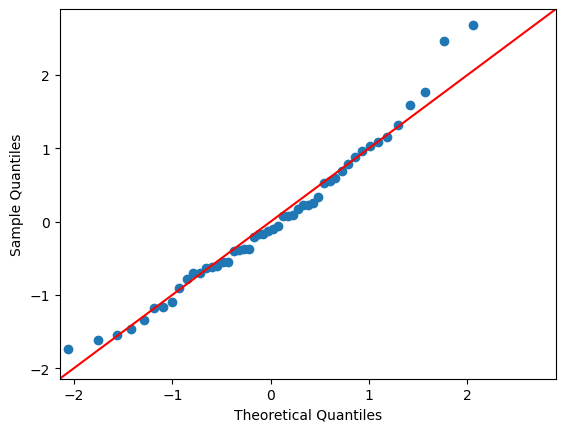

In [269]:
pc_ana('C_df_6')

In [271]:
anova('C_df_6')

ANOVA: (p=0.00 < 0.05). Reject null. The groups have a different population mean.


    [0.3, 0.1, 0.3, 0.3],     # num=7


In [272]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_7',7) 

In [273]:
# see some basic statistics of the data sets
data_C['C_df_7'].describe()

,GVWY,SHVR,ZIC,ZIP
count,50.000000,50.000000,50.000000,50.000000
mean,267.580000,304.371667,311.135000,315.355000
std,147.966371,86.443569,82.146114,93.870698
min,0.000000,156.333333,159.500000,100.833333
25%,160.750000,239.604167,261.437500,244.833333
50%,271.250000,297.166667,301.541667,315.958333
75%,378.250000,347.666667,360.062500,392.416667
max,612.000000,563.333333,483.833333,481.000000


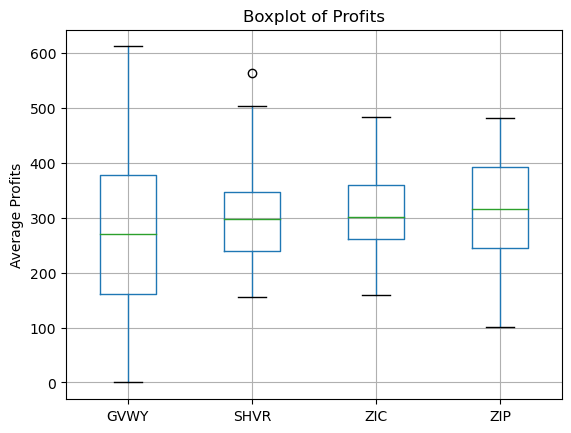

strategy GVWY. We cannot reject the null hypothesis (p=0.60). Therefore, data is normally distributed.
strategy SHVR. We can reject the null hypothesis (p=0.04). Therefore, data is not normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.17). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.62). Therefore, data is normally distributed.


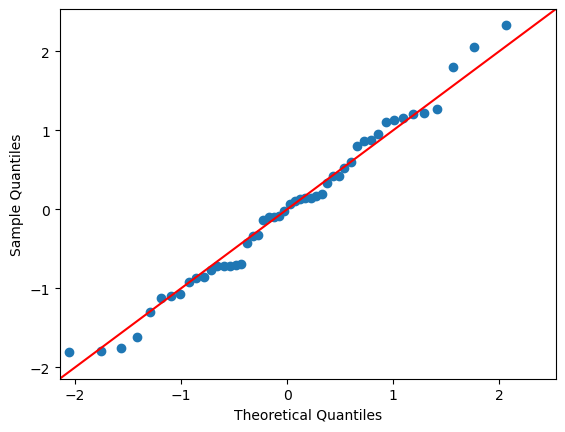

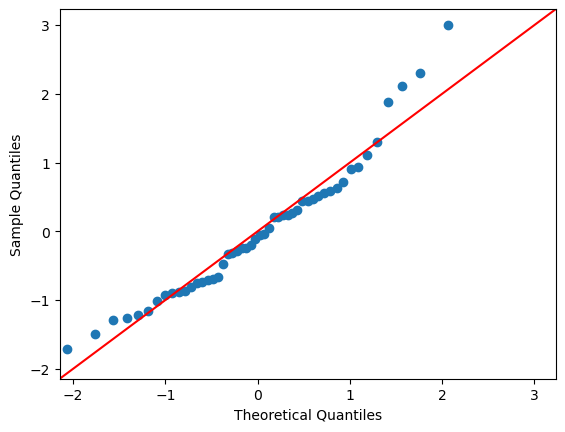

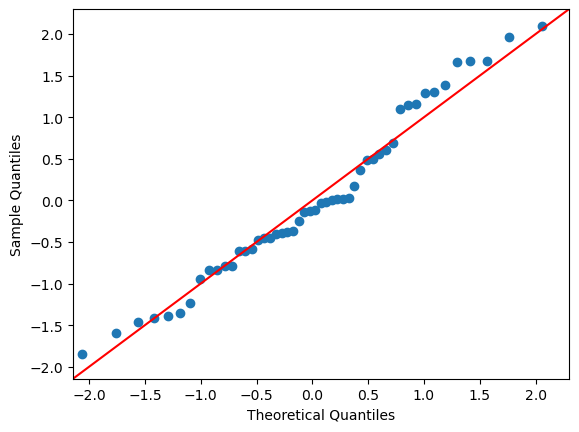

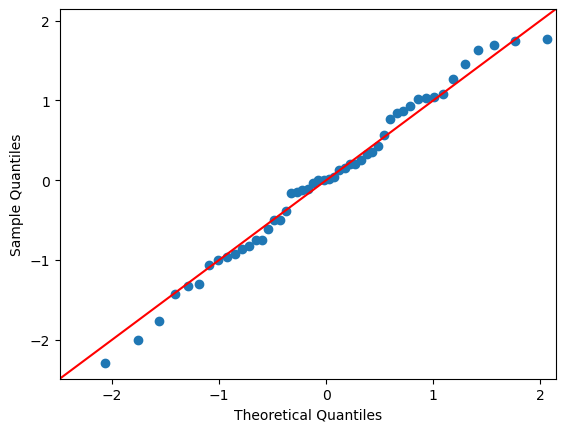

In [274]:
pc_ana('C_df_7')

In [275]:
kw('C_df_7')

Kruskal-Wallis  test: (p= 0.165 > 0.05). Cannot reject null hypothesis that the samples have identical average values


    [0.3, 0.3, 0.1, 0.3],     # num=8
   

In [276]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_8',8) 

In [277]:
# see some basic statistics of the data sets
data_C['C_df_8'].describe()

,GVWY,SHVR,ZIC,ZIP
count,50.000000,50.000000,50.000000,50.000000
mean,279.465000,292.823333,300.605000,348.223333
std,86.974214,88.013349,181.513149,91.056431
min,63.166667,111.000000,0.000000,169.500000
25%,219.625000,233.229167,175.687500,298.791667
50%,289.208333,299.750000,296.000000,347.166667
75%,337.062500,345.812500,429.562500,405.687500
max,453.750000,471.916667,756.000000,513.916667


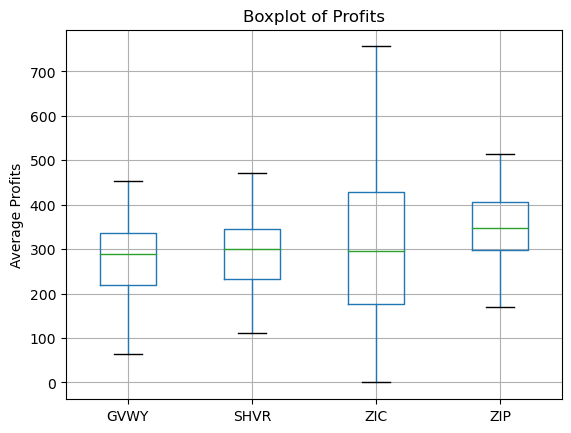

strategy GVWY. We cannot reject the null hypothesis (p=0.79). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.57). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.42). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.45). Therefore, data is normally distributed.


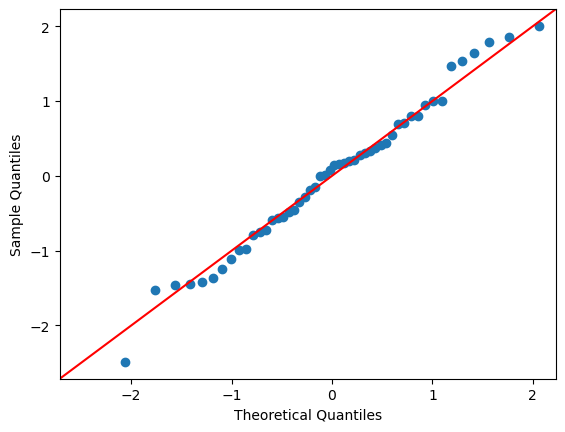

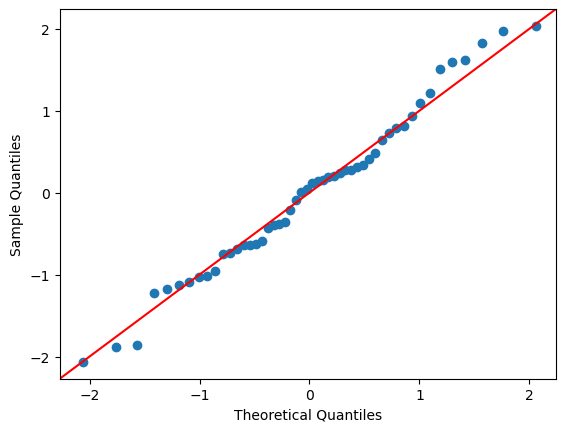

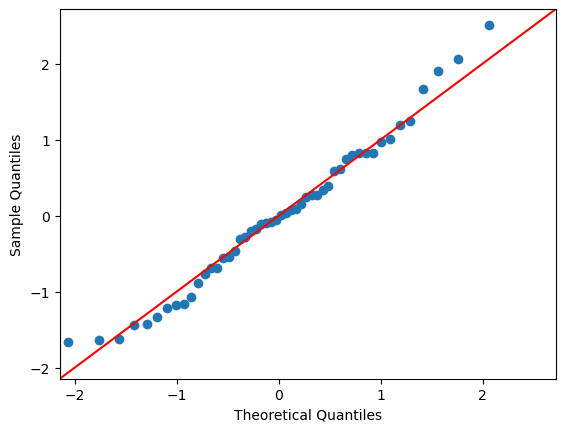

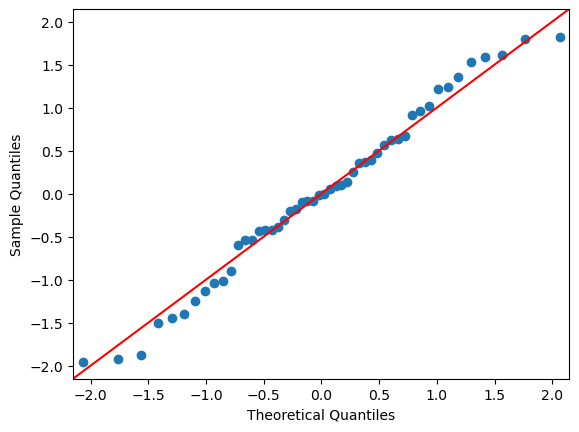

In [278]:
pc_ana('C_df_8')

In [279]:
anova('C_df_8')

ANOVA: (p=0.03 < 0.05). Reject null. The groups have a different population mean.


 [0.3, 0.3, 0.3, 0.1],     # num=9


In [280]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_9',9) 

In [281]:
# see some basic statistics of the data sets
data_C['C_df_9'].describe()

,GVWY,SHVR,ZIC,ZIP
count,50.000000,50.000000,50.000000,50.000000
mean,285.643333,298.111667,332.985000,320.035000
std,90.824674,101.821185,91.443964,170.535224
min,84.750000,73.500000,160.500000,2.500000
25%,233.354167,237.479167,269.750000,190.125000
50%,282.375000,298.583333,322.041667,331.000000
75%,340.895833,361.250000,395.229167,422.062500
max,494.416667,547.333333,587.000000,723.250000


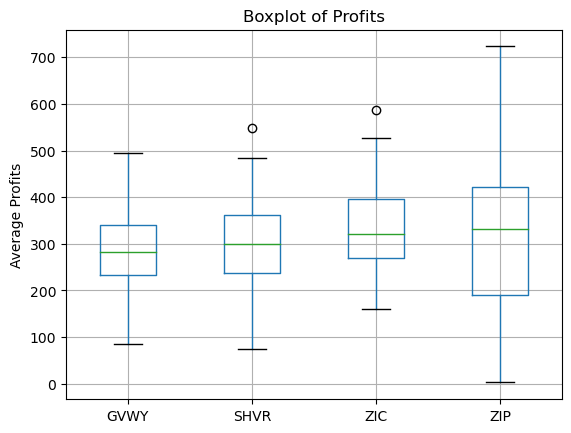

strategy GVWY. We cannot reject the null hypothesis (p=0.97). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.94). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.59). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.65). Therefore, data is normally distributed.


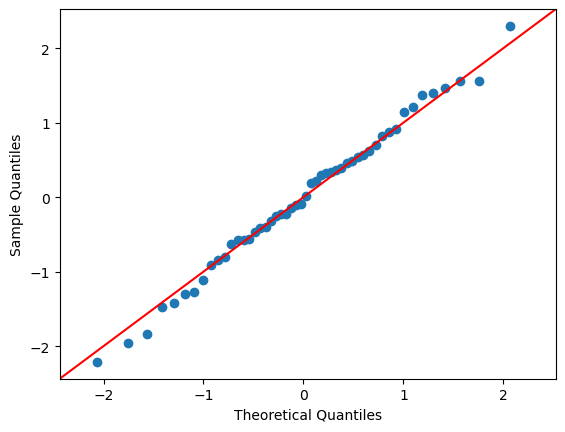

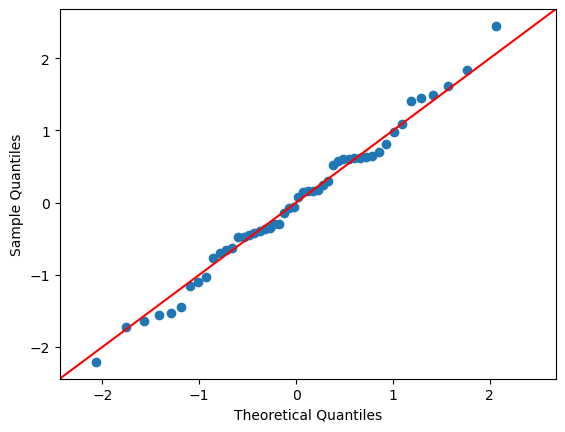

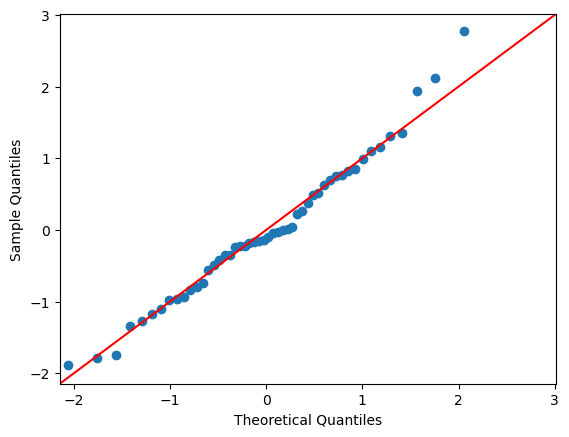

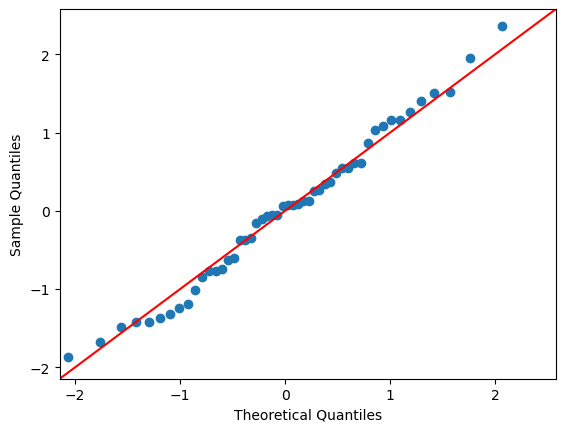

In [282]:
pc_ana('C_df_9')

In [283]:
anova('C_df_9')

ANOVA: (p=0.19 > 0.05). Cannot reject null hypothesis that groups have same population mean.


    [0.7, 0.1, 0.1, 0.1],     # num=10


In [284]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_10',10) 

In [285]:
# see some basic statistics of the data sets
data_C['C_df_10'].describe()

,GVWY,SHVR,ZIC,ZIP
count,50.000000,50.000000,50.000000,50.000000
mean,300.060000,286.713571,389.260000,378.490000
std,157.903577,37.142620,143.013967,178.021116
min,21.500000,203.357143,73.750000,41.750000
25%,196.562500,259.812500,305.562500,259.062500
50%,302.875000,278.517857,395.875000,383.125000
75%,399.000000,316.750000,482.625000,497.750000
max,670.500000,363.678571,708.250000,733.000000


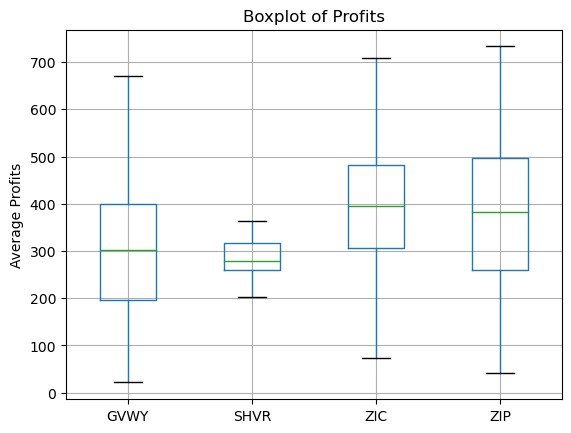

strategy GVWY. We cannot reject the null hypothesis (p=0.60). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.53). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.77). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.57). Therefore, data is normally distributed.


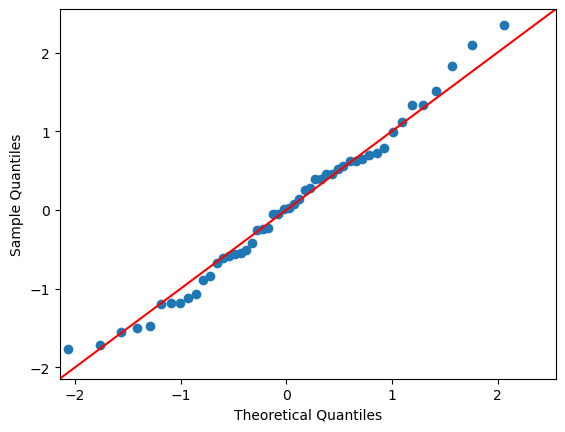

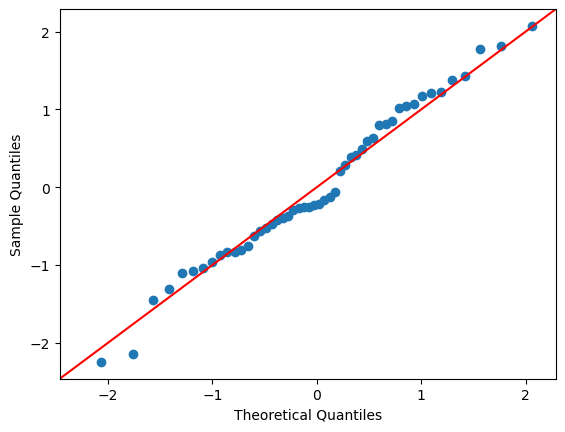

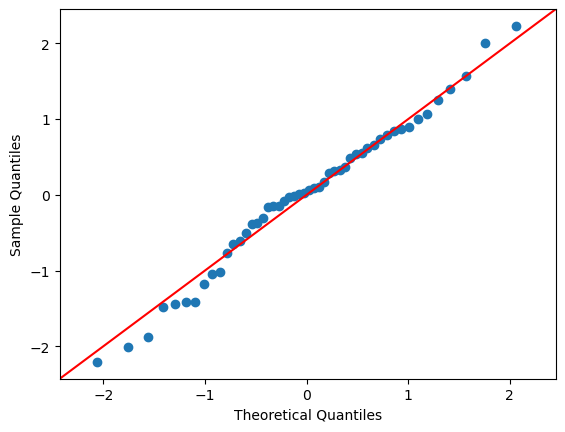

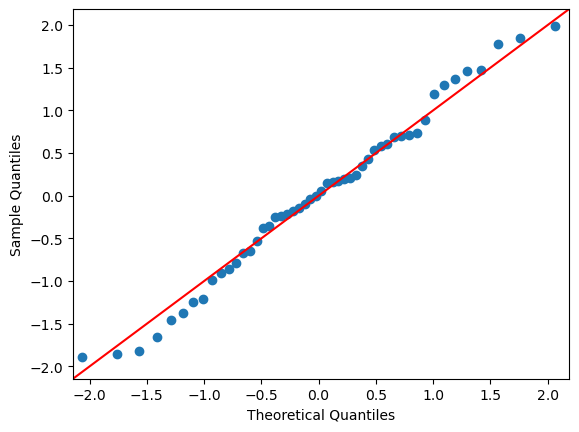

In [286]:
pc_ana('C_df_10')

In [287]:
anova('C_df_10')

ANOVA: (p=0.00 < 0.05). Reject null. The groups have a different population mean.


    [0.1, 0.7, 0.1, 0.1],     # num=11
    

In [288]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_11',11) 

In [289]:
# see some basic statistics of the data sets
data_C['C_df_11'].describe()

,GVWY,SHVR,ZIC,ZIP
count,50.000000,50.000000,50.000000,50.000000
mean,307.120000,233.925000,348.790000,336.015000
std,32.383450,152.152835,177.217477,153.224803
min,243.214286,0.000000,17.250000,13.500000
25%,286.160715,161.375000,211.937500,252.687500
50%,300.642857,228.875000,351.250000,326.875000
75%,331.232143,316.437500,455.000000,412.062500
max,378.857143,751.500000,767.750000,686.750000


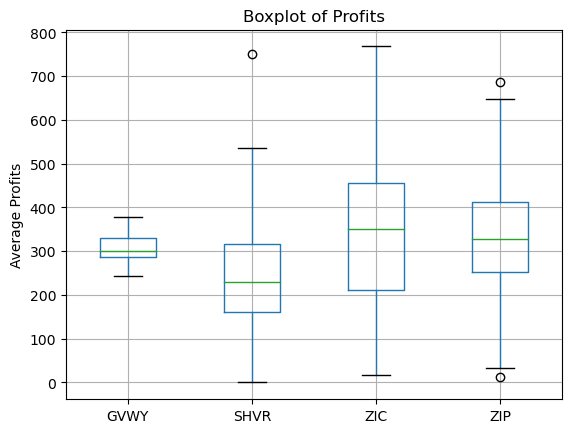

strategy GVWY. We cannot reject the null hypothesis (p=0.41). Therefore, data is normally distributed.
strategy SHVR. We can reject the null hypothesis (p=0.04). Therefore, data is not normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.54). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.45). Therefore, data is normally distributed.


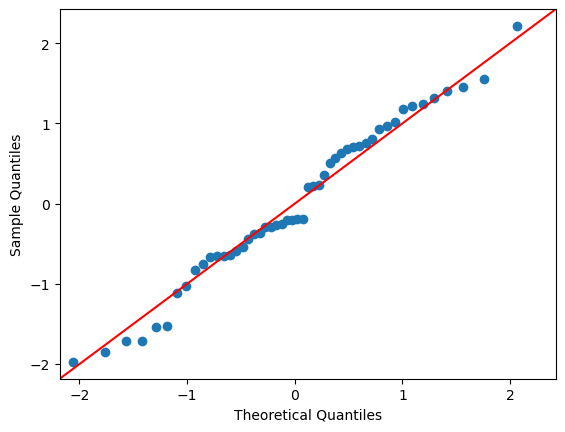

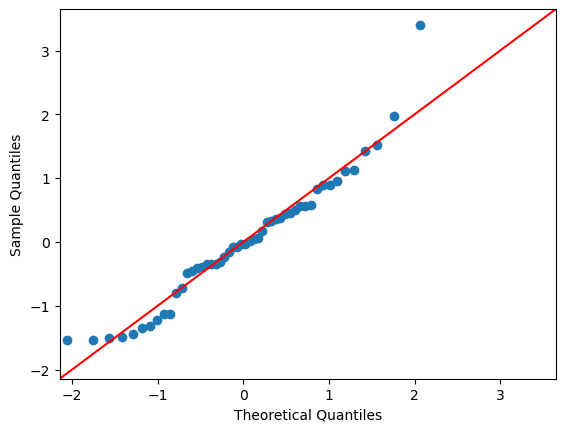

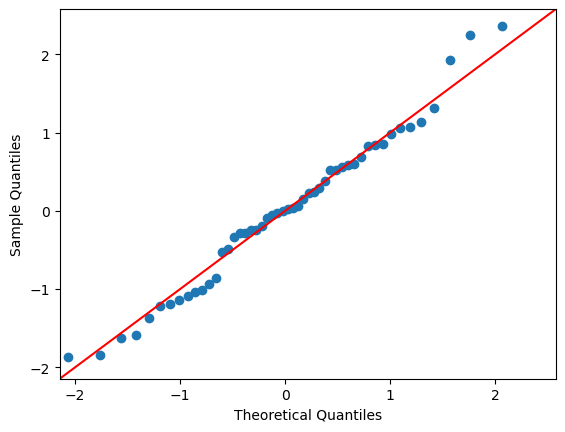

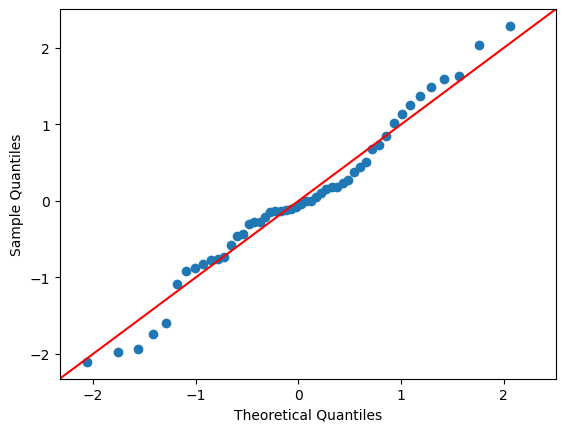

In [290]:
pc_ana('C_df_11')

In [291]:
kw('C_df_11')

Kruskal-Wallis  test: (p= 0.000 < 0.05). Reject null hypothesis that the samples have identical average values.   so there is significant difference in profits


[0.1, 0.1, 0.7, 0.1],     # num=12


In [292]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_12',12) 

In [293]:
# see some basic statistics of the data sets
data_C['C_df_12'].describe()

,GVWY,SHVR,ZIC,ZIP
count,50.000000,50.000000,50.000000,50.000000
mean,250.955000,350.995000,310.667857,281.885000
std,136.391961,154.360766,32.916757,162.677322
min,7.500000,46.000000,243.500000,40.000000
25%,145.000000,229.937500,292.535715,146.562500
50%,250.000000,363.875000,309.892857,294.875000
75%,353.500000,469.750000,322.633929,409.562500
max,527.750000,689.250000,399.892857,671.500000


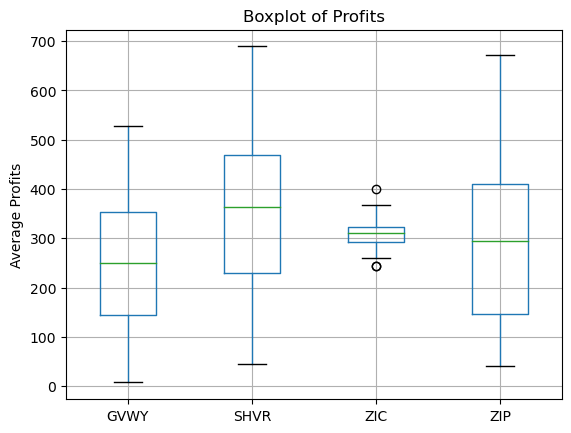

strategy GVWY. We cannot reject the null hypothesis (p=0.41). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.58). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.36). Therefore, data is normally distributed.
strategy ZIP. We can reject the null hypothesis (p=0.03). Therefore, data is not normally distributed.


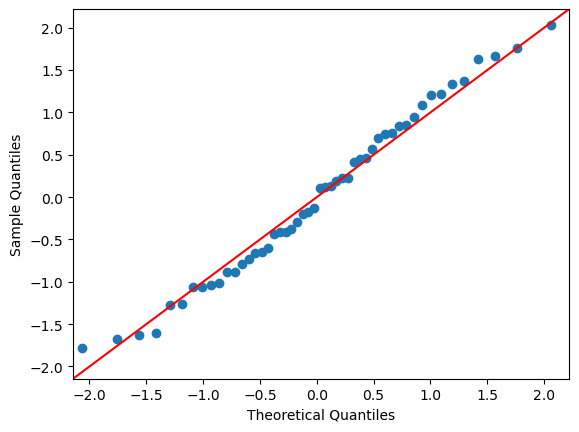

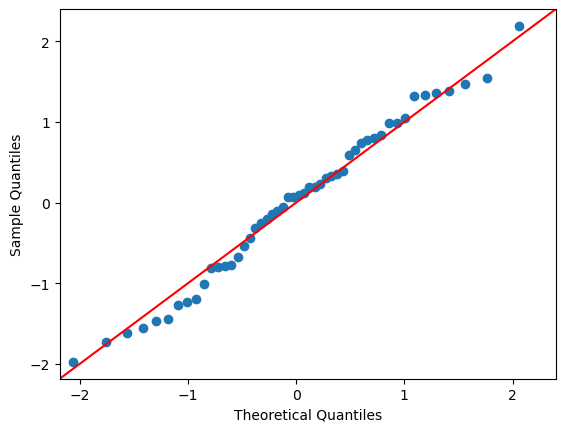

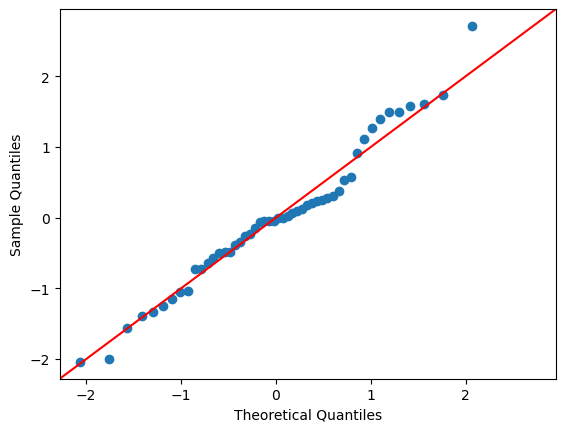

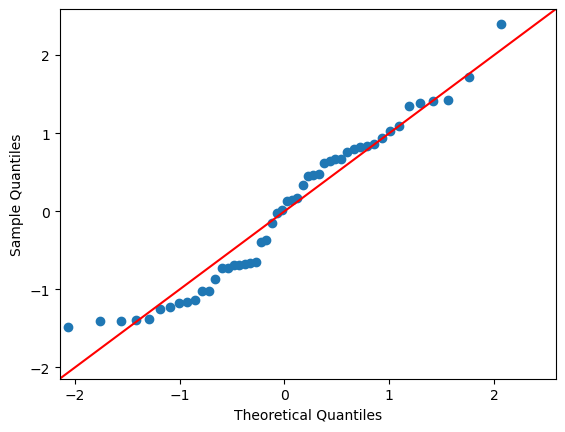

In [294]:
pc_ana('C_df_12')

In [295]:
kw('C_df_12')

Kruskal-Wallis  test: (p= 0.005 < 0.05). Reject null hypothesis that the samples have identical average values.   so there is significant difference in profits


    [0.1, 0.1, 0.1, 0.7]      # num=13

In [296]:
# run the pc_combine_data function
pc_combine_data(50,'C_df_13',13) 

In [297]:
# see some basic statistics of the data sets
data_C['C_df_13'].describe()

,GVWY,SHVR,ZIC,ZIP
count,50.000000,50.000000,50.000000,50.000000
mean,267.230000,327.895000,296.285000,305.499286
std,162.345648,191.025876,168.322236,41.135831
min,20.500000,16.000000,9.250000,228.321429
25%,131.875000,213.312500,182.750000,280.383929
50%,279.875000,326.875000,298.375000,305.428571
75%,362.375000,482.375000,399.000000,323.401785
max,664.750000,698.500000,653.500000,407.428571


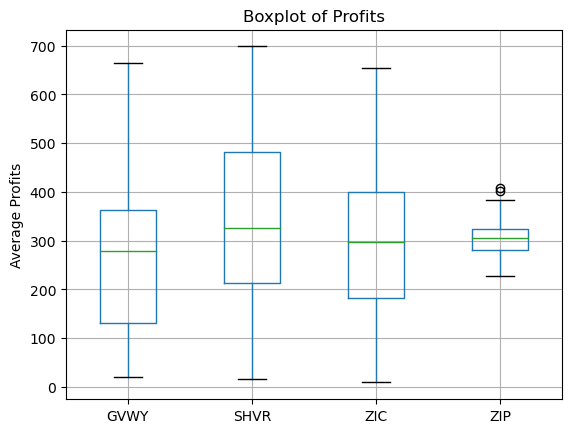

strategy GVWY. We cannot reject the null hypothesis (p=0.10). Therefore, data is normally distributed.
strategy SHVR. We cannot reject the null hypothesis (p=0.11). Therefore, data is normally distributed.
strategy ZIC. We cannot reject the null hypothesis (p=0.23). Therefore, data is normally distributed.
strategy ZIP. We cannot reject the null hypothesis (p=0.19). Therefore, data is normally distributed.


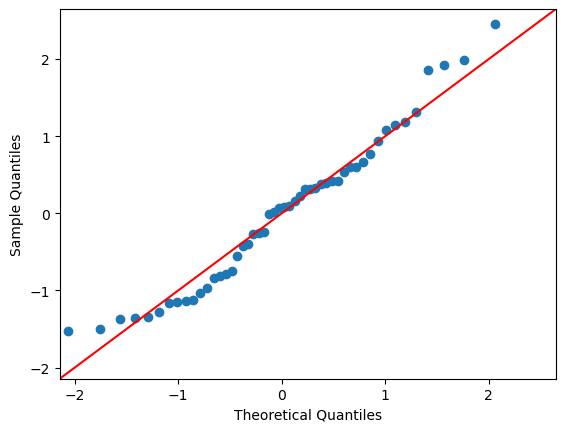

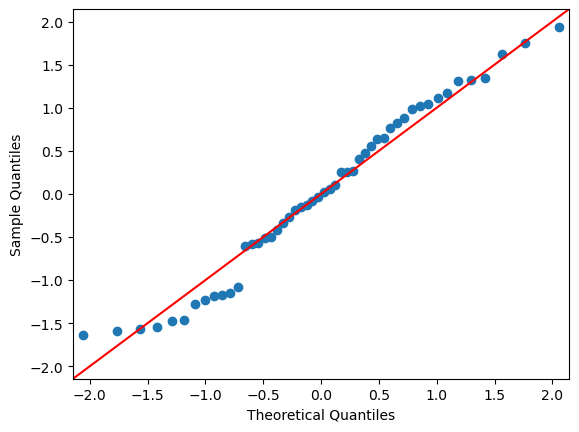

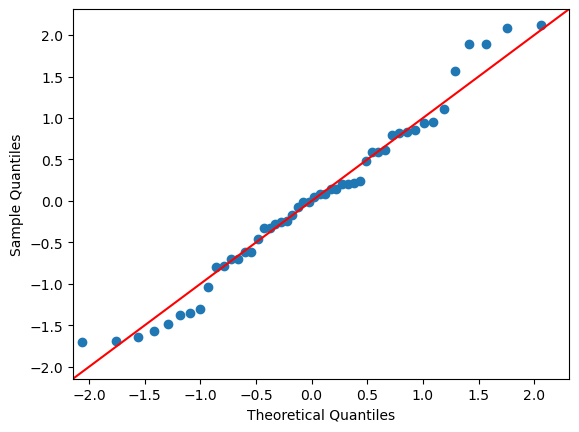

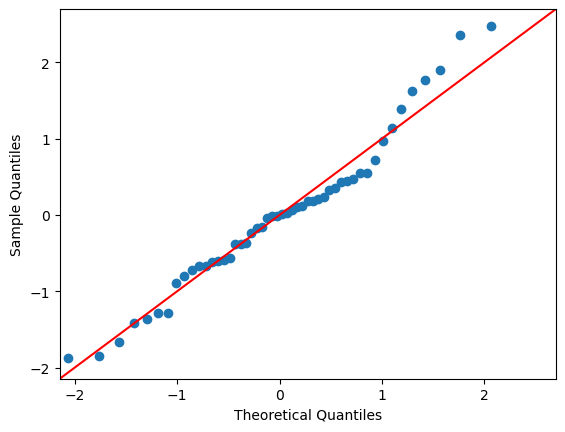

In [298]:
pc_ana('C_df_13')

In [299]:
anova('C_df_13')

ANOVA: (p=0.26 > 0.05). Cannot reject null hypothesis that groups have same population mean.


partD: 
D.1.

In [2]:
from BSE import *

def D_run_Vernon(N=10,trial_number=0): # “trial_number=0” means the first time of experiments for the entire 30 days
    start_time=0
    day=30
    end_time=60*60*24*day
    # set up supply and demand curves
    supply=(50,75)
    demand=(150, 125)

    supply_schedule=[{'from': start_time, 'to': end_time, 'ranges': [supply], 'stepmode': 'fixed'}]
    demand_schedule=[{'from': start_time, 'to': end_time, 'ranges': [demand], 'stepmode': 'fixed'}]
    order_interval=15   # change order_interval to a smaller number to reduce unnecessary time of expirement
    # change the 'timemode' into 'drip-poisson' which will be more suitable for real world
    order_sched={'sup': supply_schedule, 'dem': demand_schedule, 'interval': order_interval, 'timemode': 'drip-poisson'}

    # set up traders
    num_of_traders=10
    ZIPSH_num=int(1)
    ZIC_num=num_of_traders-ZIPSH_num
    
    buyers_spec=[('ZIPSH', 1, {'k': 4 ,'optimizer':'ZIPSH'}),('ZIC', ZIC_num)] 
    sellers_spec=[('ZIC', 10)]
    traders_spec={'sellers': sellers_spec, 'buyers': buyers_spec}

    # we need 'dump_strats',so set it "True"
    dump_flags = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': True, 'dump_avgbals': False, 'dump_tape': False}

    # run N trials
    for i in range(N):
        trial_id=f'D_{trial_number+1}_{i}'  # use the beginning 'D' to have a difference with previous files
        verbose = False
        market_session(trial_id, start_time, end_time, traders_spec, order_sched, dump_flags, verbose)



In [ ]:
# use a loop to generate 9 times of experiments
for t in range(9):
    D_run_Vernon(N=10,trial_number=t)



After generating the data, we can draw the figures to check the trend of ZIPSH.

Figure 1: profitability of a sole ZIPSH buyer in a market populated by ZIC traders. Horizontal axis is
time, labelled in days; vertical axis is the profit-per-second (PPS) generated by the ZIPSH trader.

In [36]:
# create a draw_pps function to draw the Figure 1
import glob
import pandas as pd
import matplotlib.pyplot as plt
def draw_pps(N=10,trial_number=0):
    D_folder_path = '/Users/guzhemeimao/Downloads/' 
    for n in range(N):
        D_file_paths = glob.glob(D_folder_path + f'D_{trial_number+1}_{n}_strats.csv')
        for D_file_path in  D_file_paths:    
            D_df1 = pd.read_csv(D_file_path)
    plt.ylim([0.0,3.0])   # use the code to set a fixed range of value of y axis
    D_time_X=D_df1.iloc[:,1] # it is measured in seconds
    D_day_X=D_time_X/86400  # it is measured in days 
    D_pps_Y=D_df1.iloc[:,19]
    # draw a scatter plot
    plt.scatter(D_day_X,D_pps_Y)

    plt.show



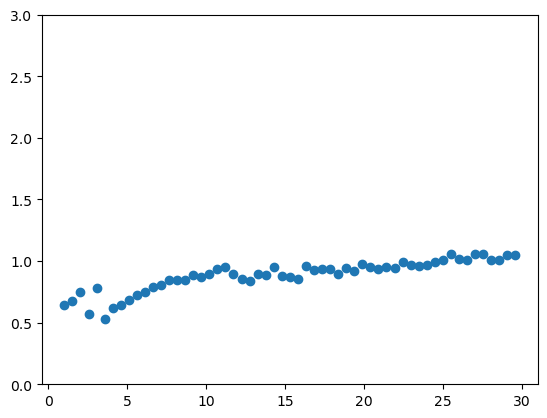

In [37]:
# invoke the function
draw_pps(trial_number=0)

As can be seen in Figure 1, there is indeed a clear improvement in profitability, which
rises from a PPS of roughly 0.5 at Day 0 to a PPS near 1.0 at Day 30, an increase of roughly 200%
in this experiment. 
It seems that the figure 1 shows that ZIPSH has an improvement in profitability.

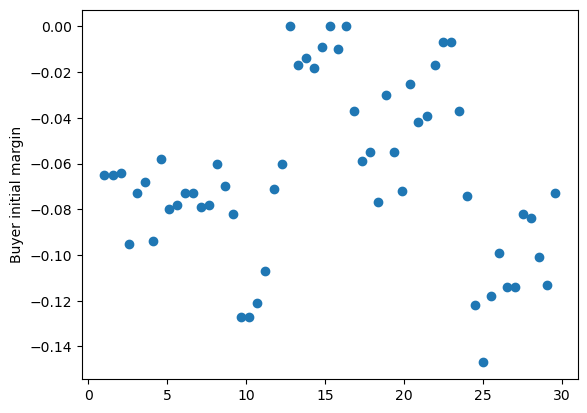

In [159]:
# create functions to draw the Figure 2
trial_number=0
N=10
D_folder_path = '/Users/guzhemeimao/Downloads/' 
for n in range(N):
    D_file_paths = glob.glob(D_folder_path + f'D_{trial_number+1}_{n}_strats.csv')
    for D_file_path in  D_file_paths:    
        D_df1 = pd.read_csv(D_file_path)
def draw_Figure2_1():
   
    # draw Buyer initial margin plot
    D_time_X=D_df1.iloc[:,1] # it is measured in seconds
    D_day_X=D_time_X/86400  # it is measured in days  
    D_buyer_Y=D_df1.iloc[:,7]
    plt.scatter(D_day_X,D_buyer_Y)
    plt.ylabel('Buyer initial margin')
    plt.show
def draw_Figure2_2():
    # draw Beta plot
    D_time_X=D_df1.iloc[:,1] # it is measured in seconds
    D_day_X=D_time_X/86400  # it is measured in days 
    D_beta_Y=D_df1.iloc[:,11]
    plt.scatter(D_day_X,D_beta_Y)
    plt.ylabel('Beta')
    plt.show
def draw_Figure2_3():
    # draw Momentum plot
    D_time_X=D_df1.iloc[:,1] # it is measured in seconds
    D_day_X=D_time_X/86400  # it is measured in days 
    D_momen_Y=D_df1.iloc[:,13]
    plt.scatter(D_day_X,D_momen_Y)
    plt.ylabel('Momentum')
    plt.show
def draw_Figure2_4():
    # draw C_a plot

    D_time_X=D_df1.iloc[:,1] # it is measured in seconds
    D_day_X=D_time_X/86400  # it is measured in days 
    D_ca_Y=D_df1.iloc[:,15]
    plt.scatter(D_day_X,D_ca_Y)
    plt.ylabel('C_a')
    plt.show
def draw_Figure2_5():

    # draw C_r plot
    
    D_time_X=D_df1.iloc[:,1] # it is measured in seconds
    D_day_X=D_time_X/86400  # it is measured in days 
    D_cr_Y=D_df1.iloc[:,17]
    plt.scatter(D_day_X,D_cr_Y)
    plt.ylabel('C_r')
    plt.show

draw_Figure2_1()


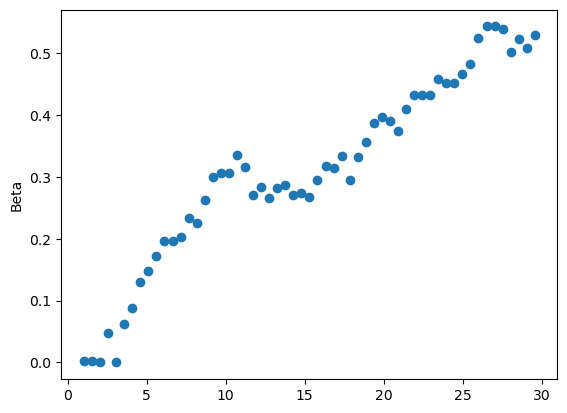

In [160]:
draw_Figure2_2()

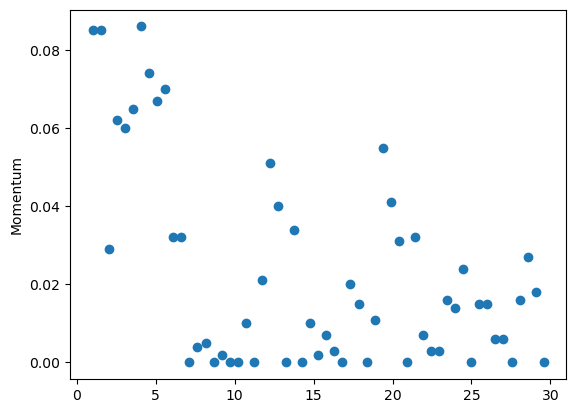

In [161]:
draw_Figure2_3()

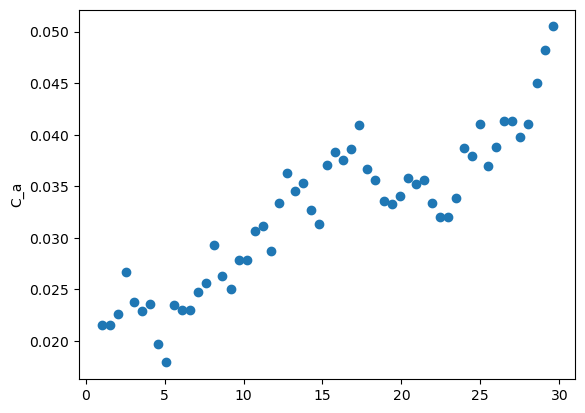

In [162]:
draw_Figure2_4()

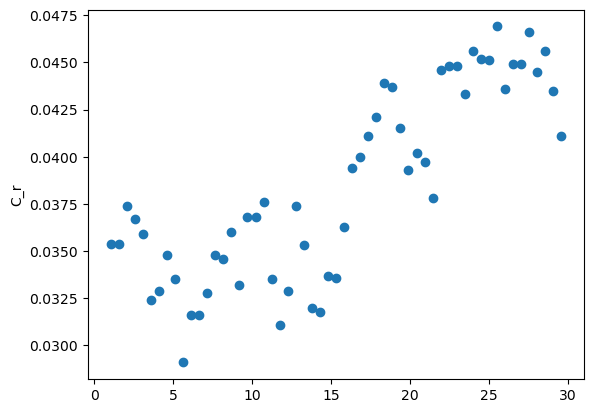

In [168]:
draw_Figure2_5()

Figure 2 shows the changes in the ZIPSH trader’s hyperparameter values over the duration of the
same experiment.
We can see each of the hyperparameters is gradually altered to get a higher profitability.

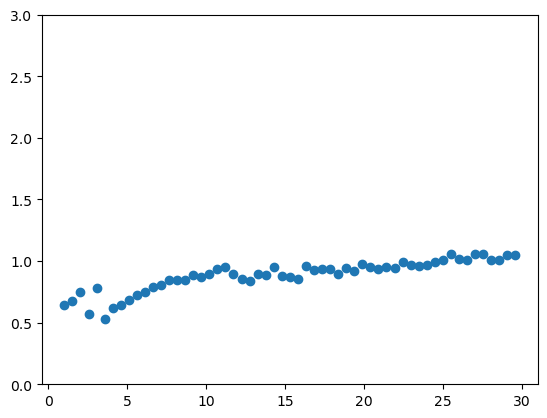

In [169]:
# invoke the function
draw_pps(trial_number=0)

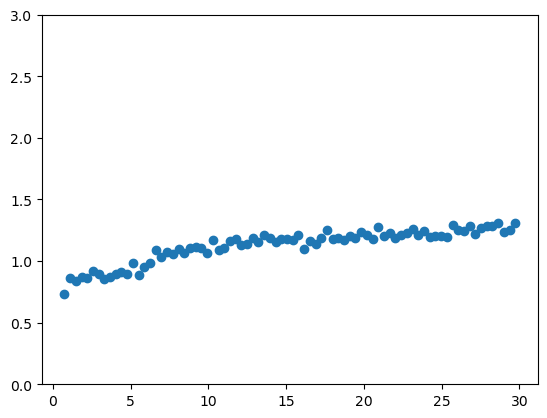

In [170]:
draw_pps(trial_number=1)

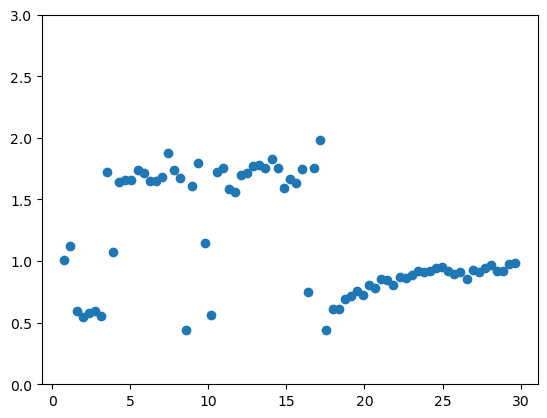

In [171]:
draw_pps(trial_number=2)

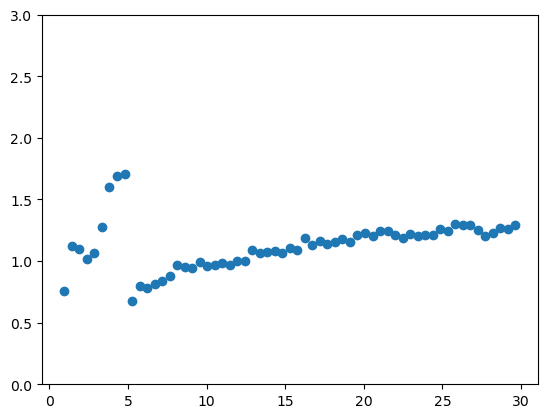

In [172]:
draw_pps(trial_number=3)

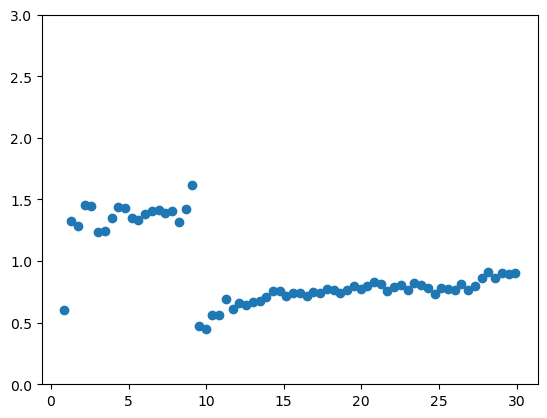

In [173]:
draw_pps(trial_number=4)

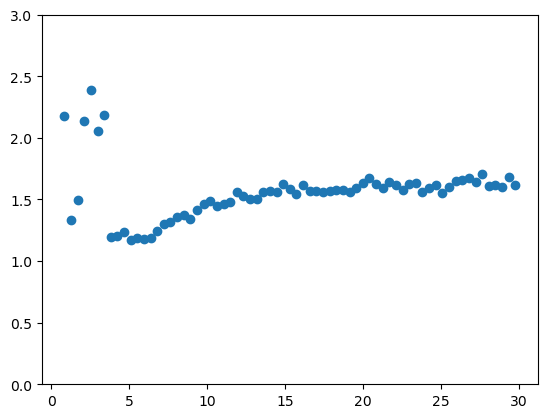

In [174]:
draw_pps(trial_number=5)

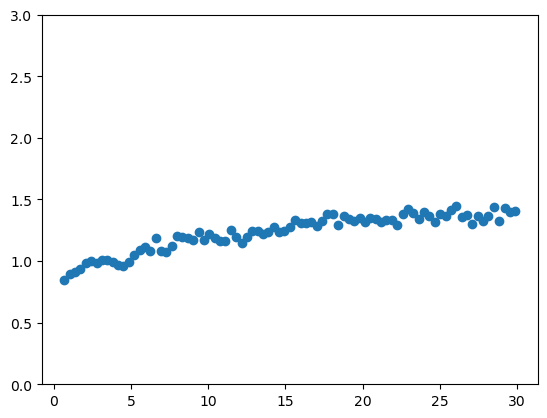

In [175]:
draw_pps(trial_number=6)

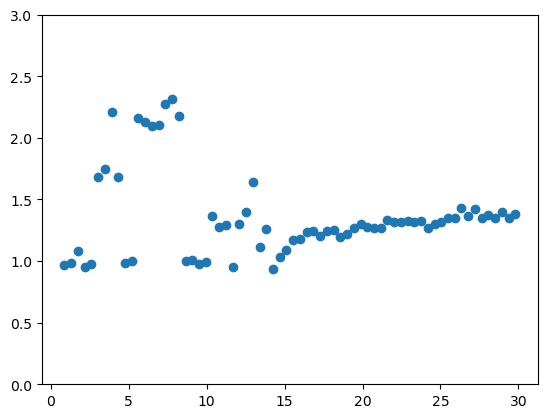

In [176]:
draw_pps(trial_number=7)

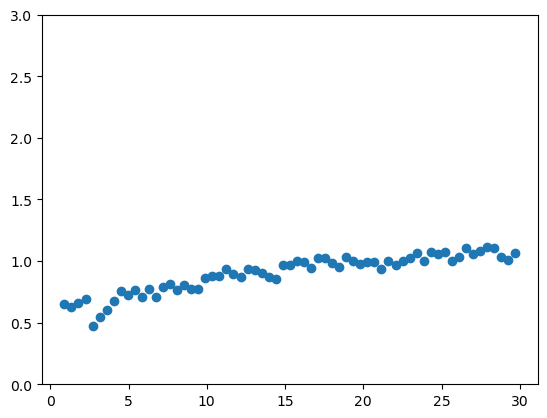

In [178]:
draw_pps(trial_number=8)

"Figure 3 shows the profitability time-series from a further nine independent and identically distributed (IID) runs of the market session that generated Figures 1."

Then, I will make some changes of the experimental metrics after replicating the experiments.
1. The sample of 10 is too small to prove, I want to change the 'N=10' to 'N=40', as a larger sample size can not only reduce the impact of outliers of the ZIPSH strategy, but also reduce the impact of noise level in the profitability scores.
2. I will alter the init_stratwaittime() function to give each strategy less evaluation time, which will increase the number of adaptive steps per day. I change the value of return to '3600+random.randint(0, 3600)'. In this way, we can use the limit 30 days of simulation to see more obvious performance. Although it will increase the noise level, the option of 'N=40' will reduce the impact, so i think it is reasonable.
3. Under the change of '1' and '2', i think 30-days is enough for us.

In [3]:
D_run_Vernon(N=40,trial_number=9)

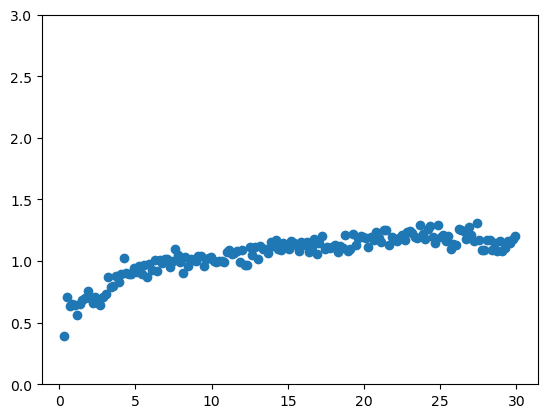

In [22]:
draw_pps(N=40,trial_number=9)

After altering the metric, the figure shows that the PPS of roughly 0.4 at Day 0 increases to near 1.2 at Day 30, it is an increase of roughly 300%.
In my opinion, the data is reliable and we can prove that the SH mechanism has made ZIP better suited to trading in the market full of ZIC traders with the special shape of supply and demand curves.

D.2.
In auction market, supply and demand curves are very important. 
They reflect the behaviours of traders. 
Generally speaking, to get more profits, we need to choose our strategies depending on the shape of supply and demand curves.
After observing the performance of ZIPSH in one shape of supply and demand curves, I would like to explore all the scenarios, and observe if there is one shape of supply and demand curves that was the most suitable one for implementing the ZIPSH strategy.

In [301]:
from BSE import *
# s1 is the initial value of the supply curve and s2 is the end value
# d1 is the initial value of the demand curve and d2 is the end value   
def D2_run_Vernon(N=10,new_name=None,s1=50,s2=75,d1=150,d2=125): # use new_name to change the name of data file
    start_time=0
    day=30
    end_time=60*60*24*day
    # change the shape of supply and demand curves to explore 
    # Set up a completely elastic demand curve
    supply=(s1,s2)
    demand=(d1,d2)
   
    supply_schedule=[{'from': start_time, 'to': end_time, 'ranges': [supply], 'stepmode': 'fixed'}]
    demand_schedule=[{'from': start_time, 'to': end_time, 'ranges': [demand], 'stepmode': 'fixed'}]
    order_interval=15   

    order_sched={'sup': supply_schedule, 'dem': demand_schedule, 'interval': order_interval, 'timemode': 'drip-poisson'}

  
    num_of_traders=10
    ZIPSH_num=int(1)
    ZIC_num=num_of_traders-ZIPSH_num
    
    buyers_spec=[('ZIPSH', 1, {'k': 4 ,'optimizer':'ZIPSH'}),('ZIC', ZIC_num)] 
    sellers_spec=[('ZIC', 10)]
    traders_spec={'sellers': sellers_spec, 'buyers': buyers_spec}


    dump_flags = {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': True, 'dump_avgbals': False, 'dump_tape': False}


    for i in range(N):
        trial_id=f'D2_{new_name}_{i}'  # change the id to make the data file name clear
        verbose = False
        market_session(trial_id, start_time, end_time, traders_spec, order_sched, dump_flags, verbose)



In [302]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
def D2_draw_pps(N=10,new_name='com_ela_d'):
    D2_folder_path = '/Users/guzhemeimao/Downloads/' 
    for n in range(N):
        D2_file_paths = glob.glob(D2_folder_path + f'D2_{new_name}_{n}_strats.csv')
        for D2_file_path in  D2_file_paths:    
            D2_df1 = pd.read_csv(D2_file_path)
    
    D2_time_X=D2_df1.iloc[:,1] # it is measured in seconds
    D2_day_X=D2_time_X/86400  # it is measured in days 
    D2_pps_Y=D2_df1.iloc[:,19]
    # draw a scatter plot
    plt.scatter(D2_day_X,D2_pps_Y)

    plt.show()



1. Completely elastic demand curve and standard supply curve

In [3]:
D2_run_Vernon(N=10,new_name='com_ela_d',d1=310,d2=310)

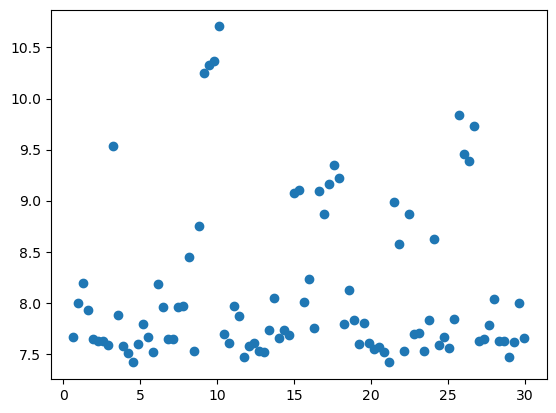

In [303]:
D2_draw_pps(N=10,new_name='com_ela_d')

Under completely elastic demand curve and standard supply curve, small changes in price can cause a big change in the demand. 
We can see in the figure that the ZIPSH not perform well. The pps don not show a trend over time.
Maybe it is because the strategy can not be able to adapt to the market conditions quickly. 

2. Steeper supply curve and standard demand curve

In [5]:
D2_run_Vernon(N=10,new_name='com_ste_s',s1=1,s2=500)

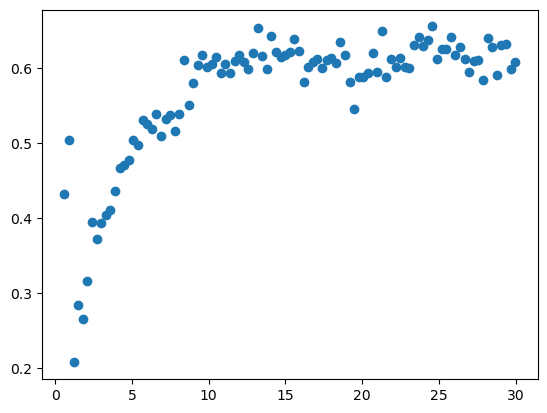

In [304]:
D2_draw_pps(N=10,new_name='com_ste_s')

The figure shows a distinct increase in pps over time. In day0, the pps is about 0.2, and in day30, the pps is about0.7, an increase of roughly 350%.
We can know that ZIPSH is suitable for the market with a steeper supply curve and standard demand curve.

3. Steeper supply curve and completely elastic demand curve

In [7]:
D2_run_Vernon(N=10,new_name='com_ste_s_ela_d',s1=1,s2=500,d1=310,d2=310)

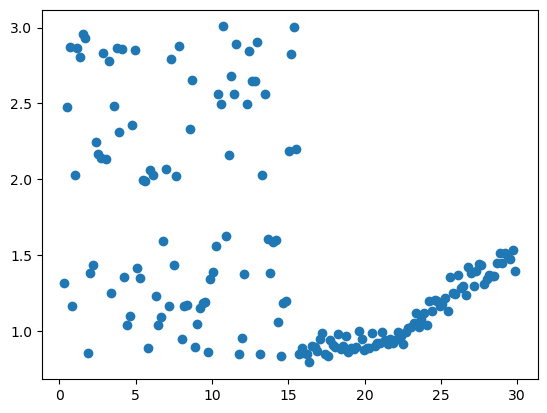

In [17]:
D2_draw_pps(N=10,new_name='com_ste_s_ela_d')

It seems that the pps has a decrease trend over time during day0 to day15, while, during day15 to day30, the pps has a increase trend over time. 
So, to explore more useful information, we need to set a new trail with time longer than 30 days.

4. Steeper demand curve and standard supply curve 

In [11]:
D2_run_Vernon(N=10,new_name='com_in_d',d1=1,d2=500)

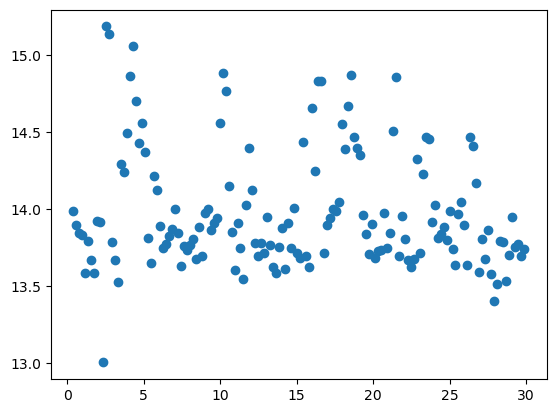

In [19]:
D2_draw_pps(N=10,new_name='com_in_d')

Under steeper demand curve and standard supply curve, this means that changes in prices do not significantly affect demand.  
We can see in the figure that the ZIPSH not perform well. The pps don not show a trend over time.
This may because even if ZIPSH can find the better parameters, the change on trading order may be limited, so it can not be visualized in such a extreme market situation.

5. Completely inelastic supply curve and standard demand curve 

In [9]:
D2_run_Vernon(N=10,new_name='com_in_s',s1=310,s2=310)

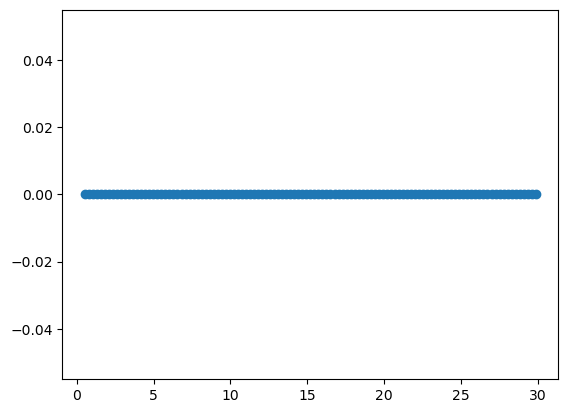

In [307]:
D2_draw_pps(N=10,new_name='com_in_s')

6. Steeper demand curve and completely inelastic supply curve 

In [305]:
D2_run_Vernon(N=10,new_name='com_ste_d_in_s',s1=310,s2=310,d1=1,d2=500)

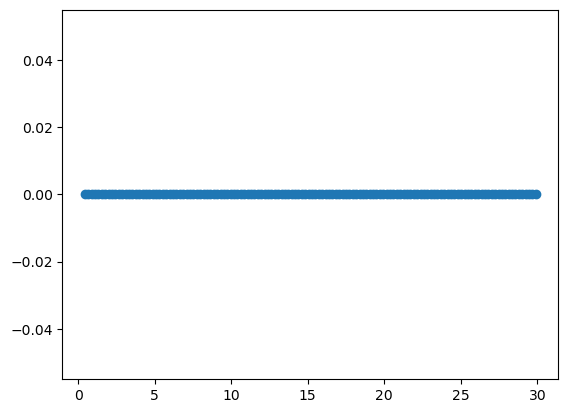

In [306]:
D2_draw_pps(N=10,new_name='com_ste_d_in_s')

The situation of 5 and 6 have the same figures which show that ZIPSH can not gain any profit in the market.
In such market, price can not influence the supply, so the completely inelastic supply curve make it impossible for all traders to gain profit.

Some text...

END OF REPORT. ONLY WORD COUNT BELOW THIS POINT. 

In [311]:
# Do not edit this code. It will print the word count of your notebook.
import io
from nbformat import current

def printWordCount(filepath):

    with io.open(filepath, 'r', encoding='utf-8') as f:
        nb = current.read(f, 'json')

    word_count = 0
    for cell in nb.worksheets[0].cells:
        if cell.cell_type == "markdown":
            word_count += len(cell['source'].replace('#', '').lstrip().split(' '))
    print("Word count: " + str(word_count) + ". Limit is 2000 words.")

In [312]:
# This should be the final output of your notebook.
# Edit filename to be the same as this filename and then run.
# Save your file before running this code.

this_file_name = "CW-INFT-2475879.ipynb" # Enter name of this file here
printWordCount(this_file_name)

Word count: 1884. Limit is 2000 words.
